# Imports

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import warnings
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# Config

In [ ]:
LR_PATH = '/content/drive/MyDrive/RC/output/time_interval_lr_result.parquet'
XGB_PATH = '/content/drive/MyDrive/RC/output/time_interval_XGB_result.parquet'
TEST_DATE = '2023-04-01'

# Load Data

In [ ]:
def load_data(file_paths):
    df = pd.read_parquet(file_paths).reset_index()
    return df

## Linear regression model

In [ ]:
lr_rides_df = load_data(LR_PATH)

print(lr_rides_df.shape)
lr_rides_df.head()

(62880, 8)


date  time_interval_number  PU_day_of_week  last_day_demand  \
0 2023-04-01                     1               5            142.0   
1 2023-04-01                     1               5            161.0   
2 2023-04-01                     1               5            447.0   
3 2023-04-01                     1               5             78.0   
4 2023-04-01                     1               5            305.0   

   last_week_demand  PULocationID  real demand  predicted demand  
0             165.0           161          161             161.0  
1             448.0           107          480             397.0  
2             359.0           132          364             377.0  
3             103.0           138          156              98.0  
4             910.0           114          848             804.0

## XGBoost model

In [ ]:
xgb_rides_df = load_data(XGB_PATH)

print(xgb_rides_df.shape)
xgb_rides_df.head()

(62880, 8)


date  time_interval_number  PU_day_of_week  last_day_demand  \
0 2023-04-01                     1               5            142.0   
1 2023-04-01                     1               5            161.0   
2 2023-04-01                     1               5            447.0   
3 2023-04-01                     1               5             78.0   
4 2023-04-01                     1               5            305.0   

   last_week_demand  PULocationID  real demand  predicted demand  
0             165.0           161          161             180.0  
1             448.0           107          480             449.0  
2             359.0           132          364             425.0  
3             103.0           138          156             115.0  
4             910.0           114          848             825.0

# Evaluation

In [ ]:
predictions_dict = {
    'baseline_last_week' : None,
    'regression_model' : None,
    'xgboost_model' : None
}

predictions_dict['regression_model'] = lr_rides_df[
    [
        'date',
        'time_interval_number',
        'PULocationID',
        'predicted demand'
    ]
]

predictions_dict['xgboost_model'] = xgb_rides_df[
    [
        'date',
        'time_interval_number',
        'PULocationID',
        'predicted demand'
    ]
]

predictions_dict['baseline_last_week'] = xgb_rides_df[
    [
        'date',
        'time_interval_number',
        'PULocationID',
        'last_week_demand'
    ]
].rename(
    columns = {'last_week_demand' : 'predicted demand'}
)

## Report by Metrics

### Calculate metrics for all predictions model per all LocationIDs

In [ ]:
PULocationIDs_Metrics = {}
PULocationIDs = xgb_rides_df['PULocationID'].unique()
PULocationIDs.sort()
metrics_all = []
for i in range(1, 9):
    for key in predictions_dict:
        for locationID in PULocationIDs:
            selected_df_model = predictions_dict[key][
                (predictions_dict[key]['PULocationID'] == locationID) &
                (predictions_dict['xgboost_model']['time_interval_number'] == i)
            ]
            selected_df_actual = xgb_rides_df[
                (xgb_rides_df['PULocationID'] == locationID) &
                (xgb_rides_df['time_interval_number'] == i)
            ]
            if selected_df_actual.shape[0] != 0:
              metric_mape = mean_absolute_percentage_error(
                  selected_df_actual['real demand'],
                  selected_df_model['predicted demand']
              )
              metric_mae = mean_absolute_error(
                  selected_df_actual['real demand'],
                  selected_df_model['predicted demand']
              )
              metric_mse = mean_squared_error(
                  selected_df_actual['real demand'],
                  selected_df_model['predicted demand'],
              )
              metric_rmse = math.sqrt(metric_mse)
              metrics_all.append(
                  {
                      'PULocationID' : locationID,
                      'time_interval_number' : i,
                      'Model': key,
                      'MAPE': metric_mape,
                      'MAE': metric_mae,
                      'RMSE': metric_rmse
                  }
              )
    PULocationIDs_Metrics[i] = pd.DataFrame(metrics_all)
    metrics_all=[]

print(PULocationIDs_Metrics[1].shape)
PULocationIDs_Metrics[1].head()

(786, 6)


PULocationID  time_interval_number               Model      MAPE  \
0             1                     1  baseline_last_week  0.200000   
1             2                     1  baseline_last_week  0.000000   
2             3                     1  baseline_last_week  0.000000   
3             4                     1  baseline_last_week  0.415606   
4             5                     1  baseline_last_week  0.116667   

         MAE       RMSE  
0   0.266667   0.516398  
1   0.000000   0.000000  
2   0.000000   0.000000  
3  12.566667  22.444747  
4   0.166667   0.408248

# Visualization

## Compare Models prediction vs. Last week count base on MAPE metric

In [ ]:
def plot_model_metric(df, sorted_df, lower, upper, metrics, interval):
    PULocationIDs_Metrics_Selected = sorted_df[
        sorted_df['PULocationID'].isin(df.iloc[lower:upper, 0])
    ]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected['PULocationID'].astype('str')
    plt.figure(figsize = (20, 5) , clear = True)
    sns.lineplot(
        data = PULocationIDs_Metrics_Selected,
        x = 'PULocationID',
        y = metrics,
        hue = 'Model'
    )
    plt.xticks(rotation = 90)
    plt.title(f'Metric {metrics} For Location Id and time interval {interval} ')
    plt.show()

In [ ]:
xgb_rides_df_sorted = {}
PULocationIDs_Metrics_sorted = {}
for i in range(1, 9):
      xgb_rides_df_sorted[i] = xgb_rides_df.query(
          "time_interval_number == @i"
      ).groupby(['PULocationID', 'time_interval_number'])[['real demand']].mean().sort_values(
          'real demand',
          ascending = False
      ).reset_index()
      dummy = pd.Series(xgb_rides_df_sorted[i]['PULocationID']).to_frame()
      PULocationIDs_Metrics_sorted[i] = pd.merge(
          dummy,
          PULocationIDs_Metrics[i],
          on = 'PULocationID',
          how = 'left'
      )

### checking

In [ ]:
PULocationIDs_Metrics_sorted[1][PULocationIDs_Metrics_sorted[1]['PULocationID'] == 79]

PULocationID  time_interval_number               Model      MAPE  \
0            79                     1  baseline_last_week  0.183802   
1            79                     1    regression_model  0.431670   
2            79                     1       xgboost_model  0.164301   

          MAE        RMSE  
0  117.500000  197.207589  
1  131.533333  197.671782  
2   78.266667  117.593084

### High Demand

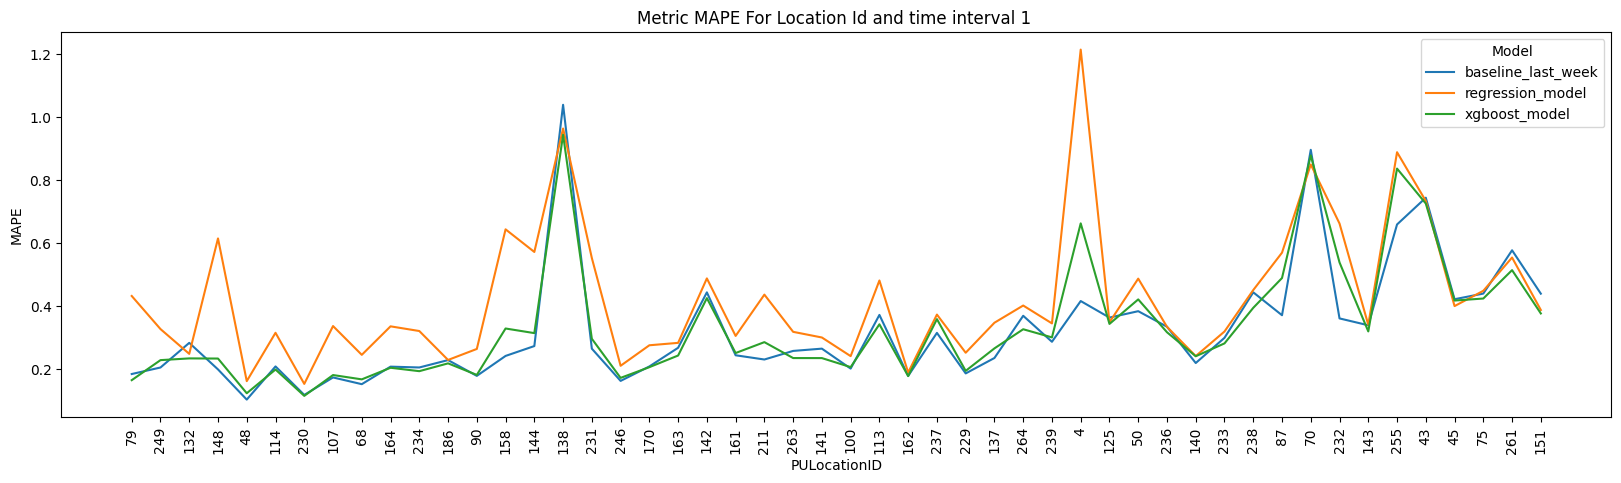

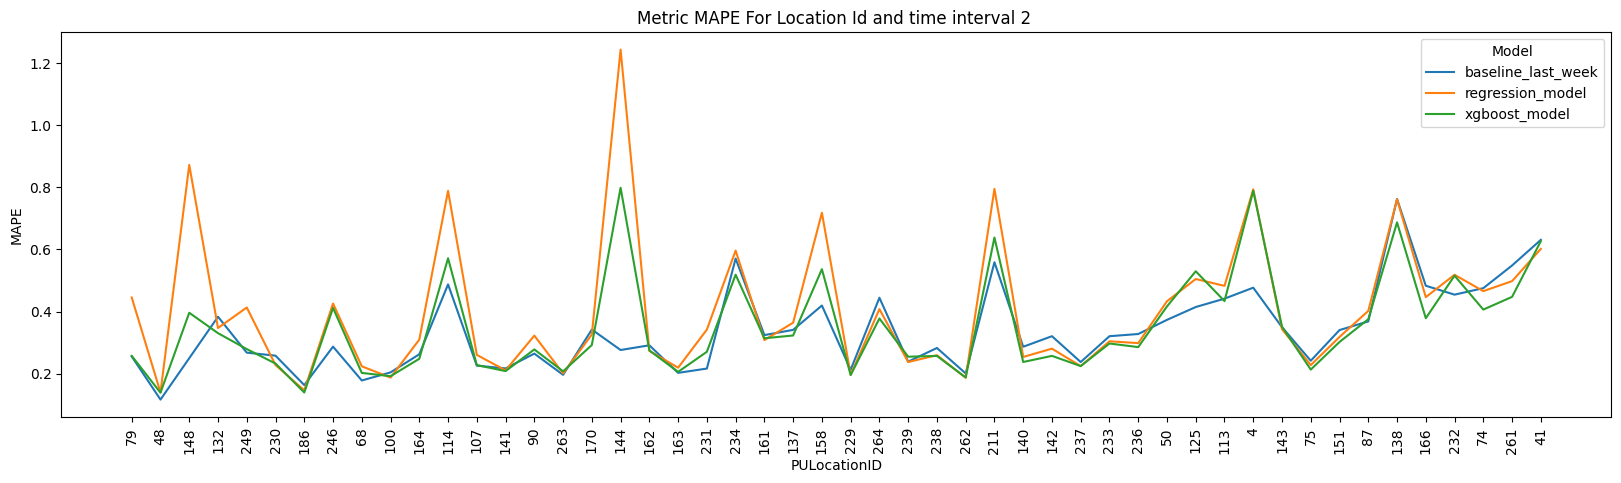

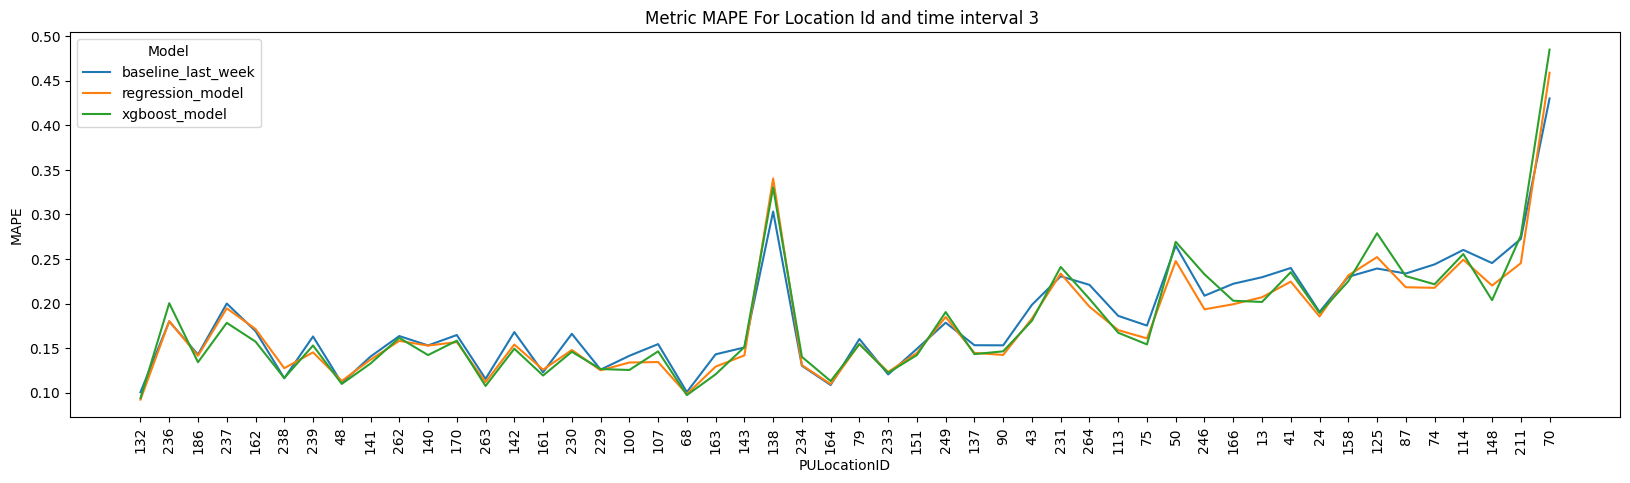

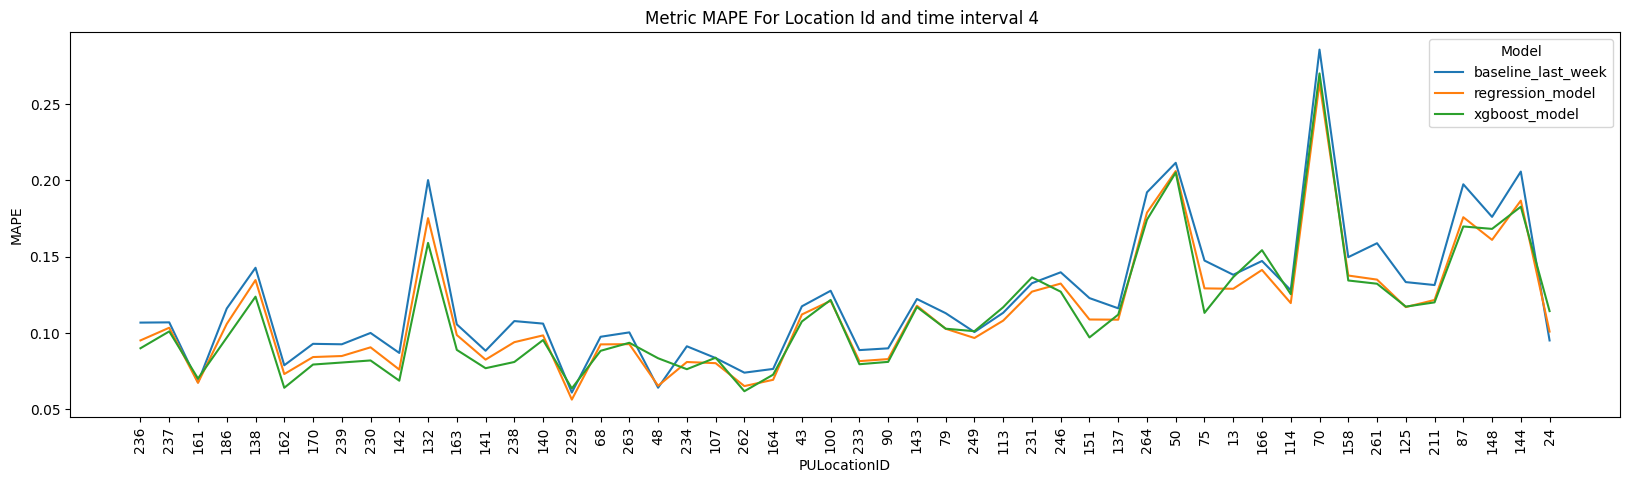

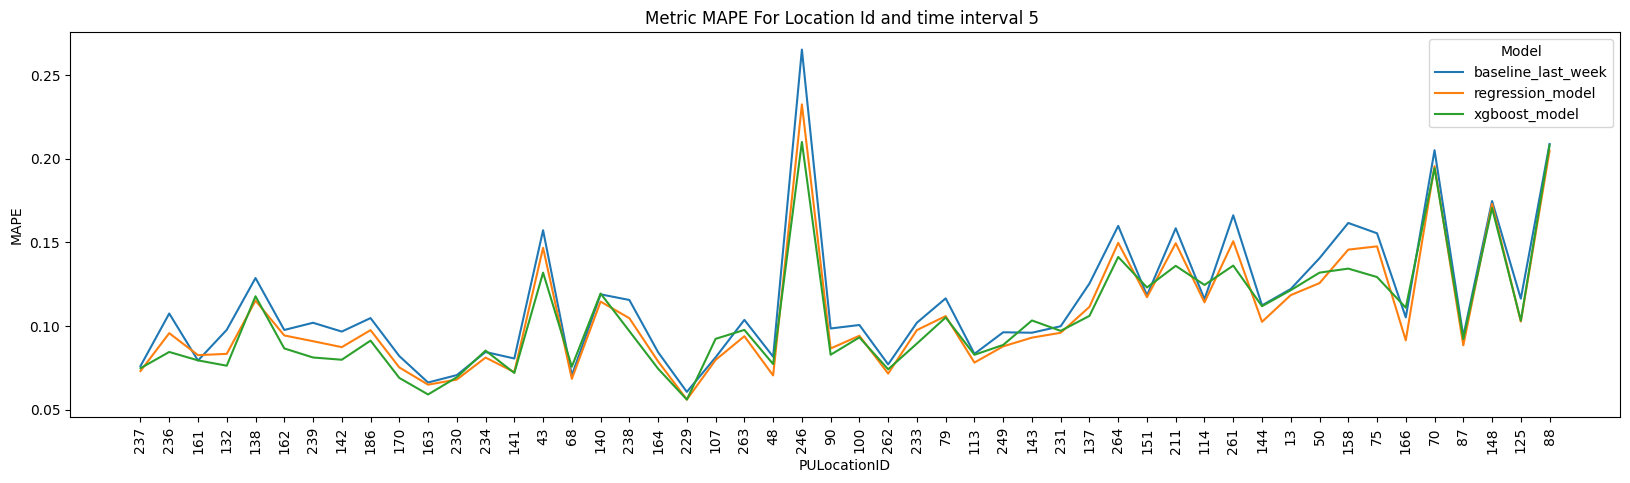

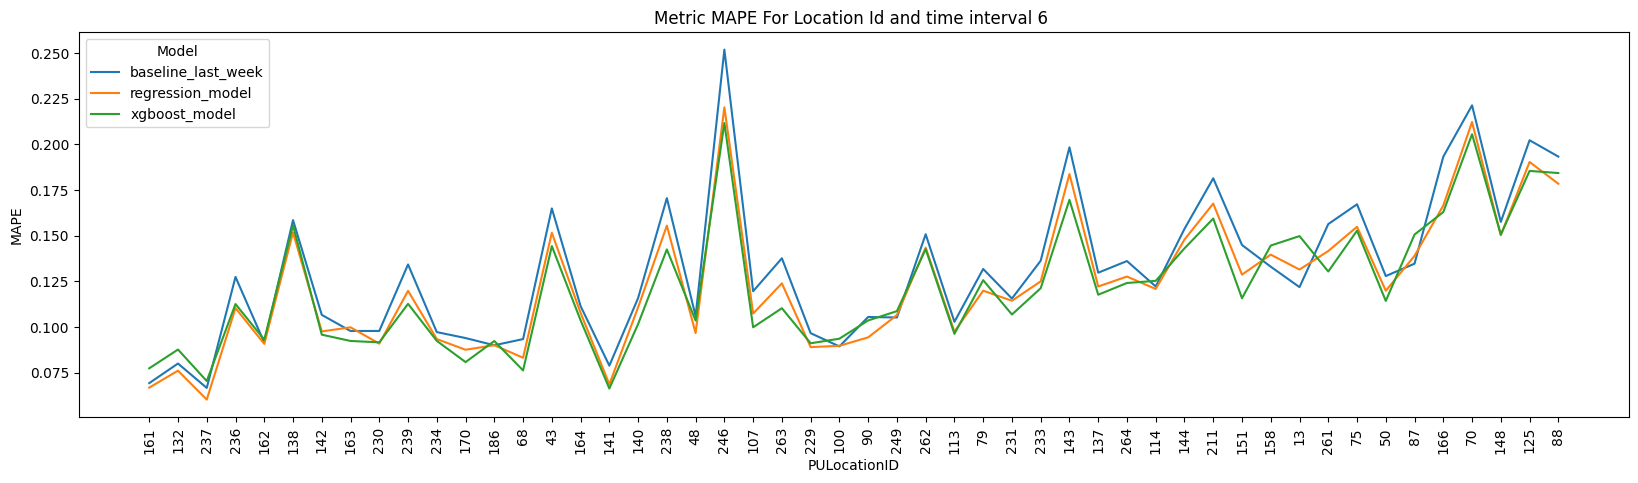

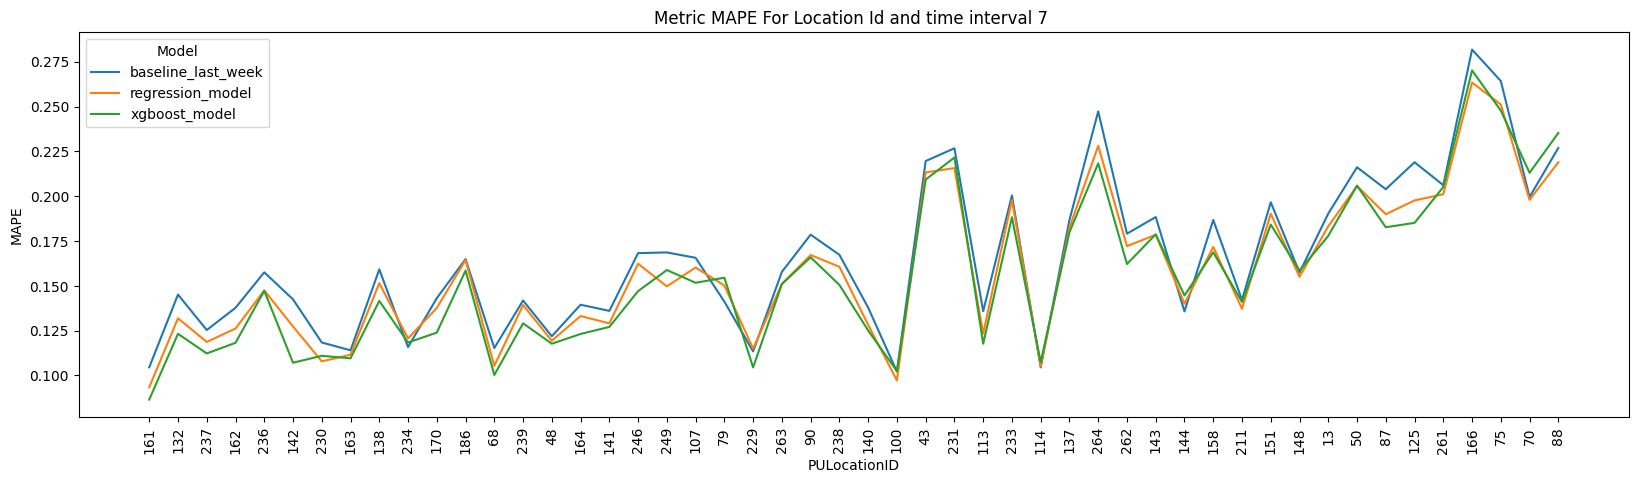

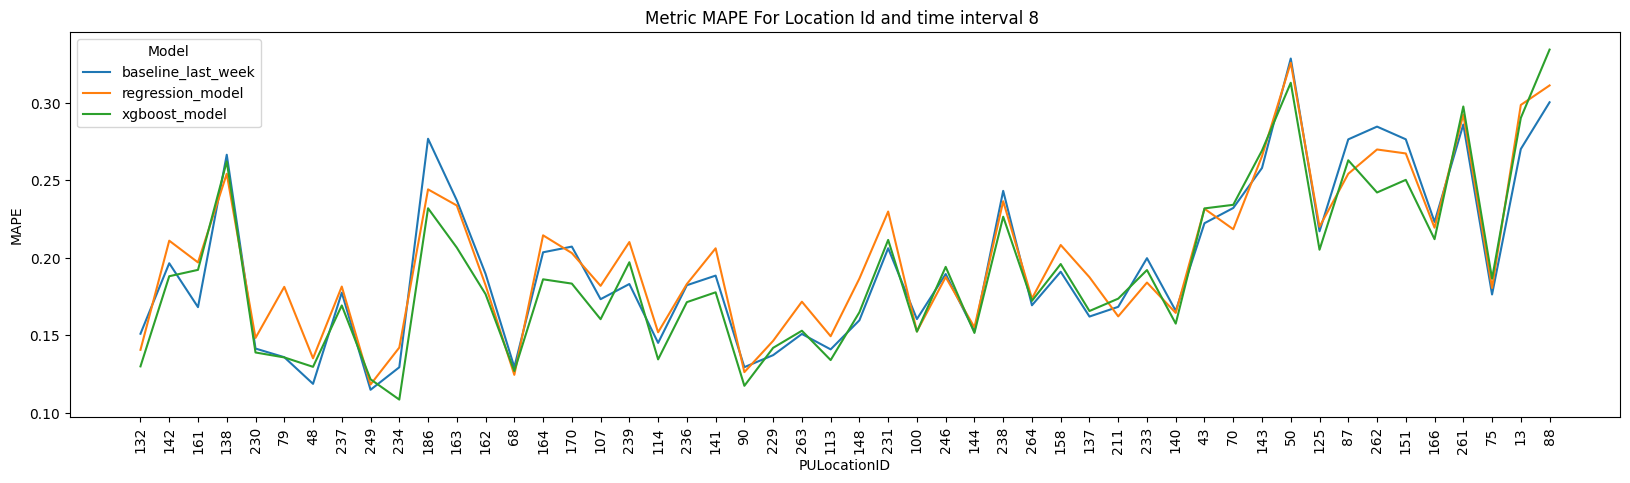

In [ ]:
for interval in range(1, 9):
    plot_model_metric(
        xgb_rides_df_sorted[interval],
        PULocationIDs_Metrics_sorted[interval],
        0,
        50,
        'MAPE',
        interval
    )

### Mid Demand

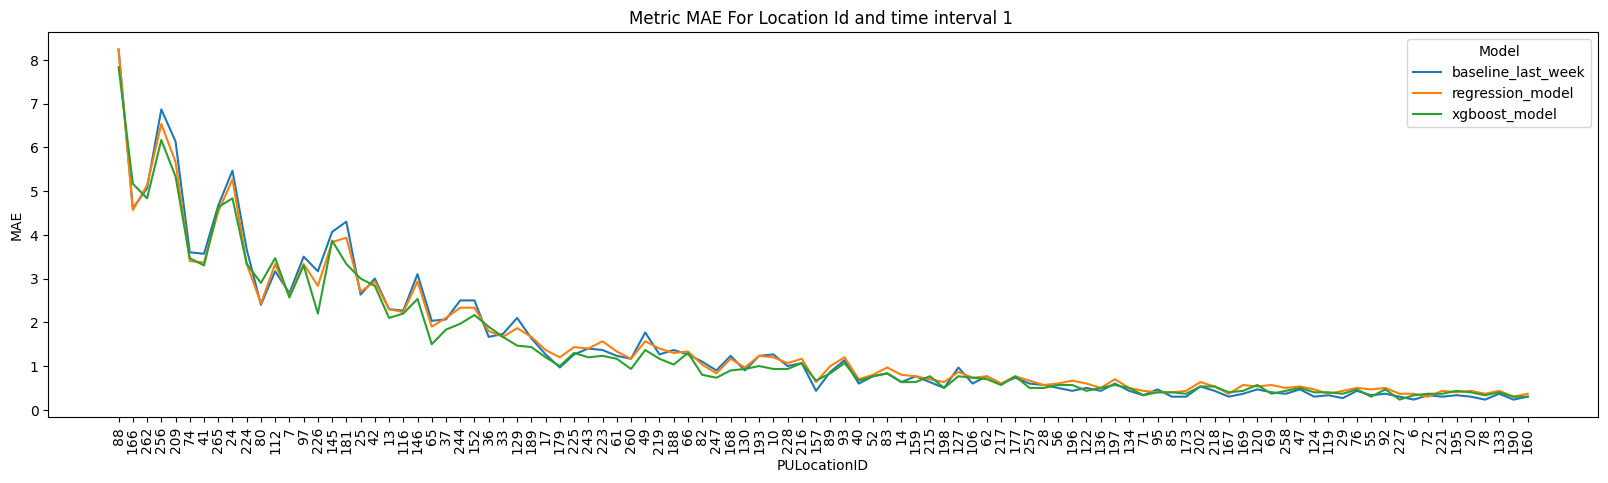

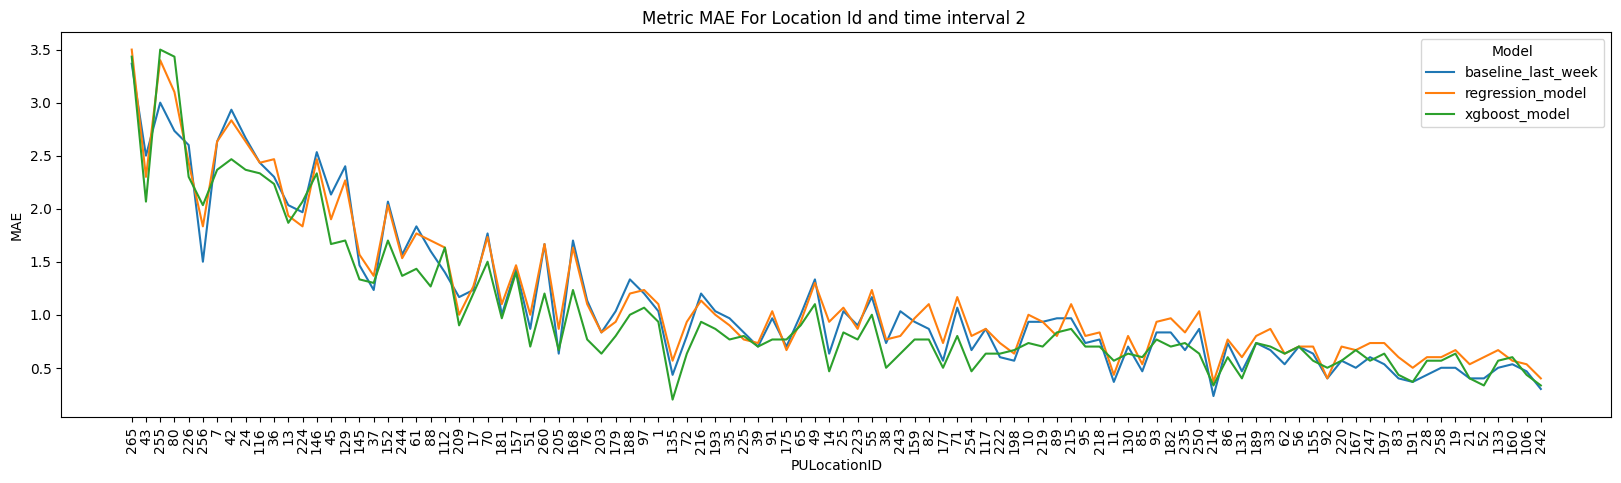

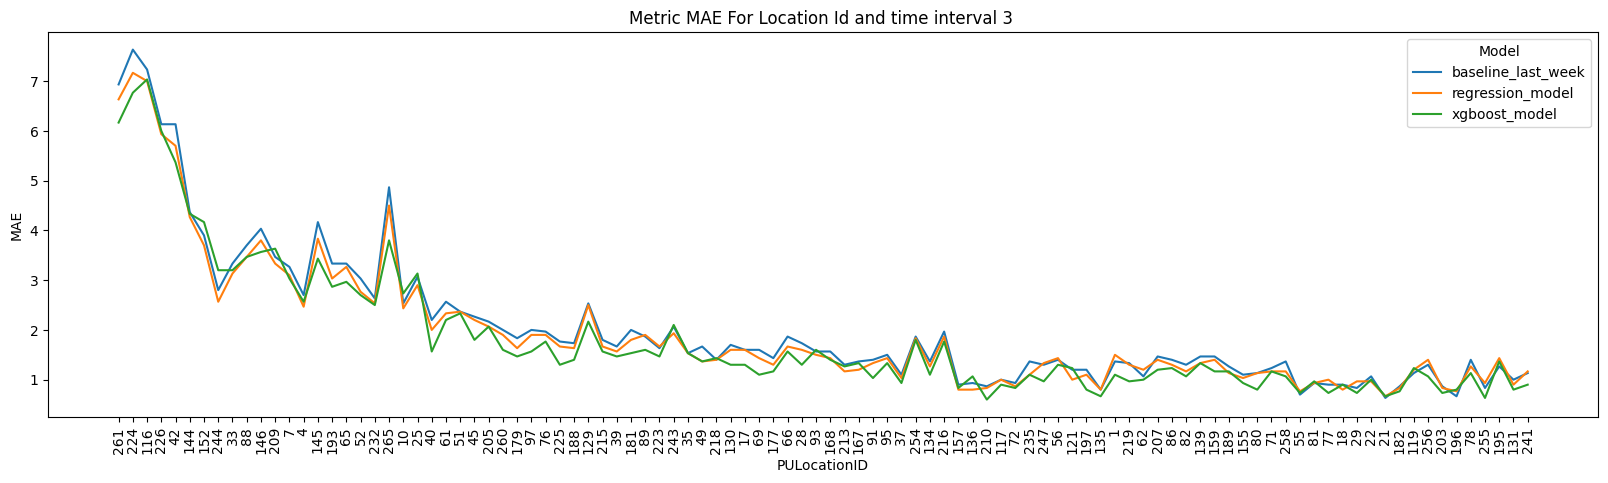

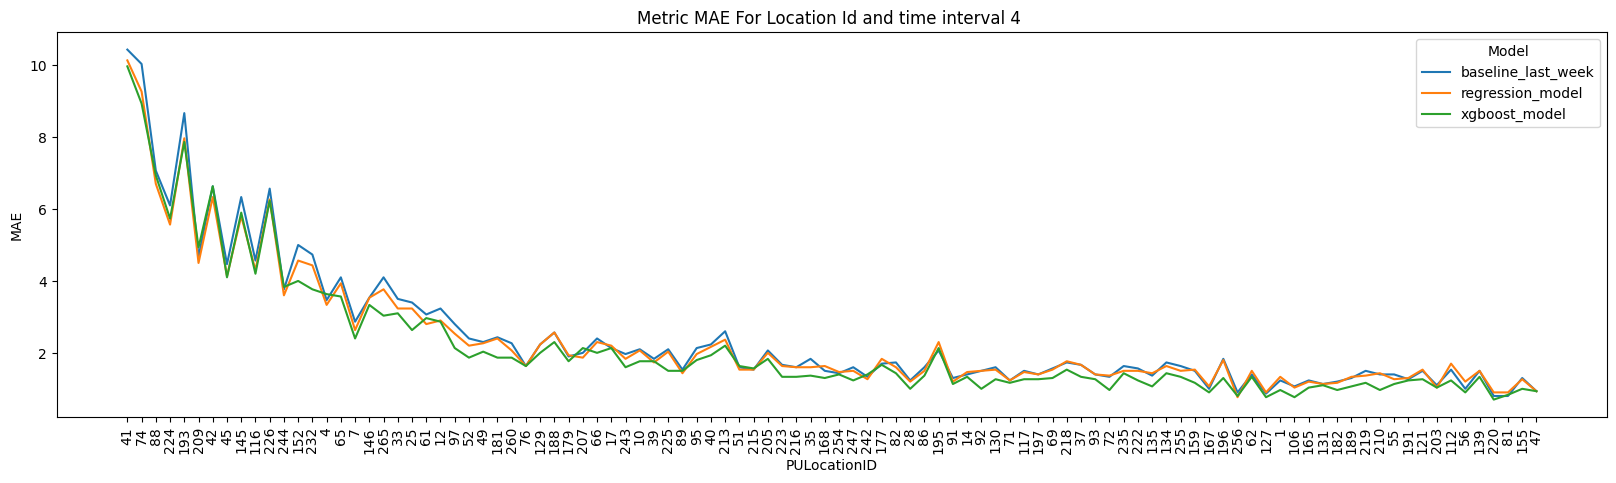

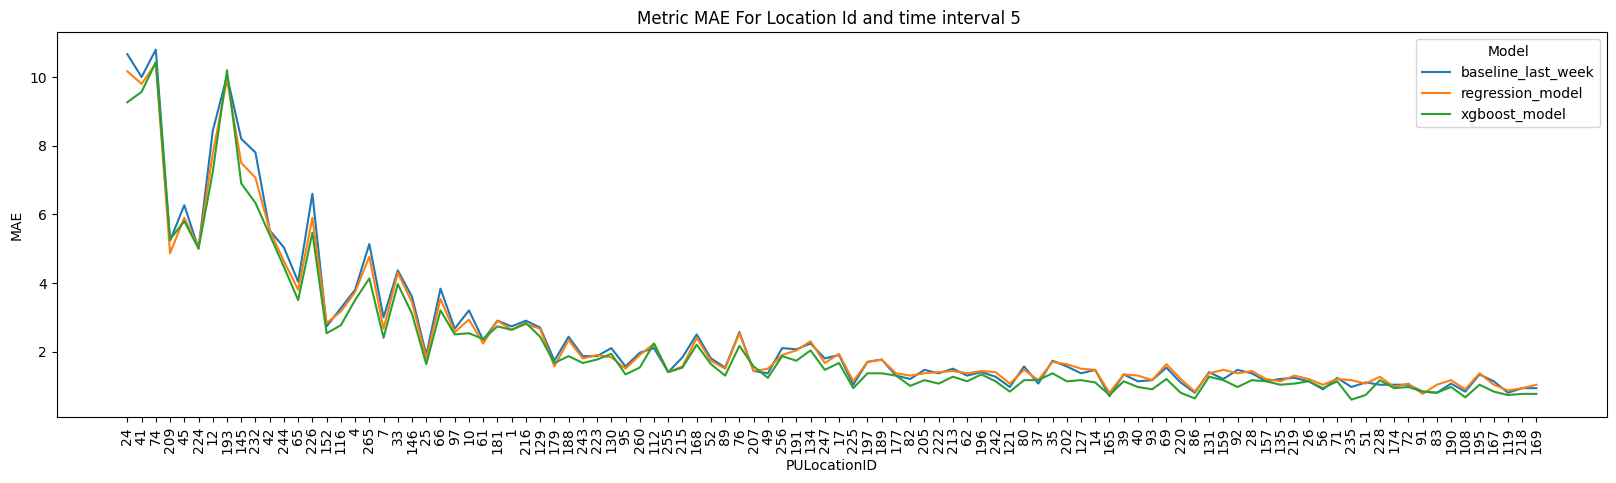

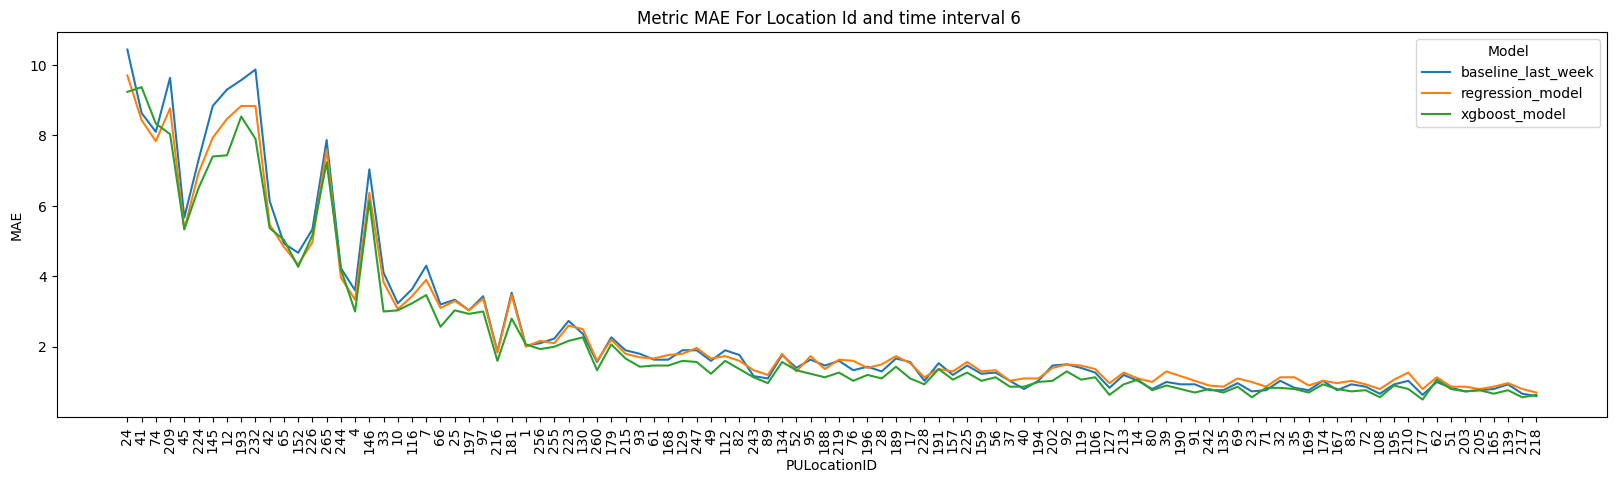

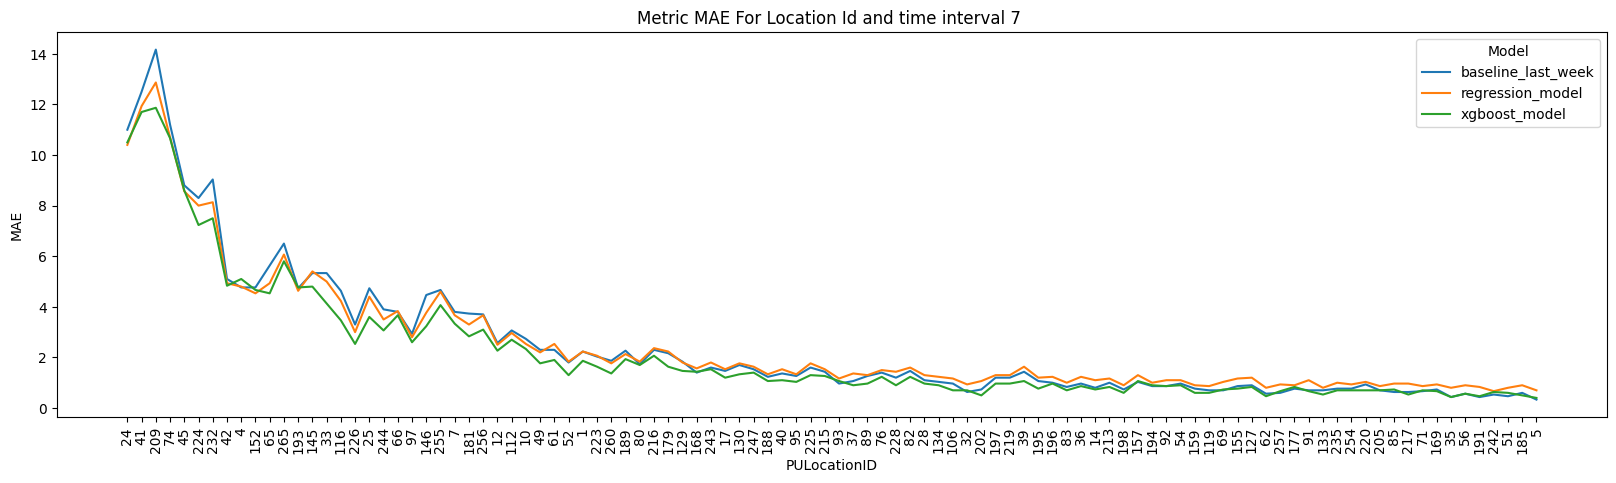

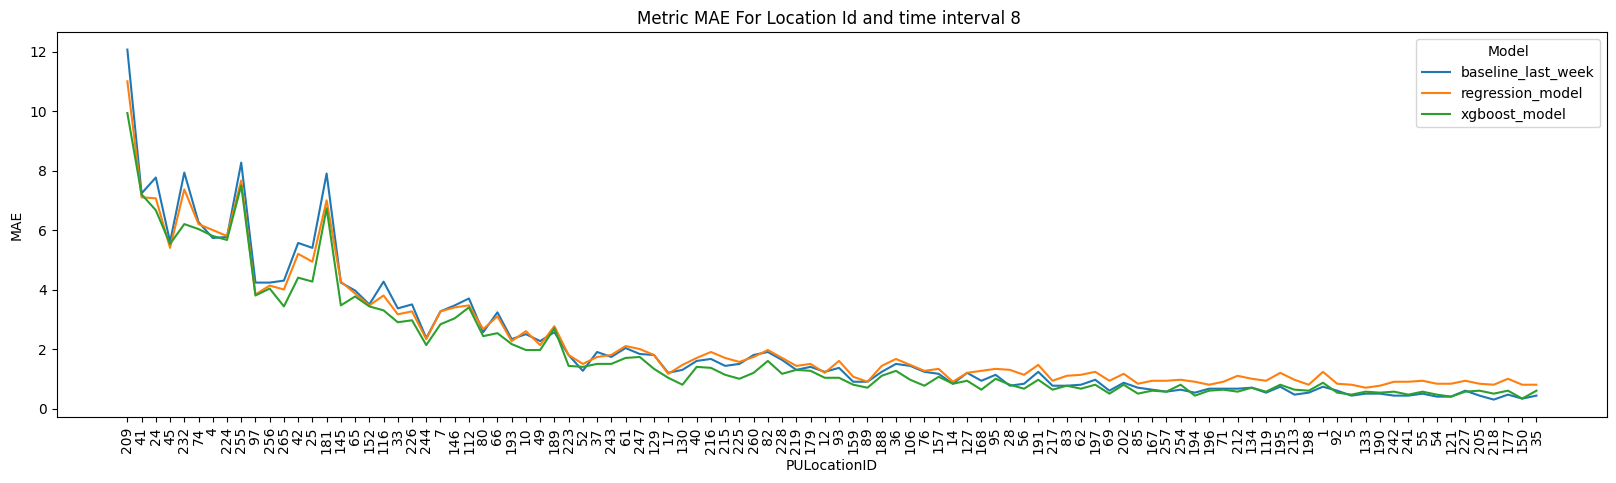

In [ ]:
for interval in range(1, 9):
    plot_model_metric(
        xgb_rides_df_sorted[interval],
        PULocationIDs_Metrics_sorted[interval],
        50,
        150,
        'MAE',
        interval
    )

### Low Demand

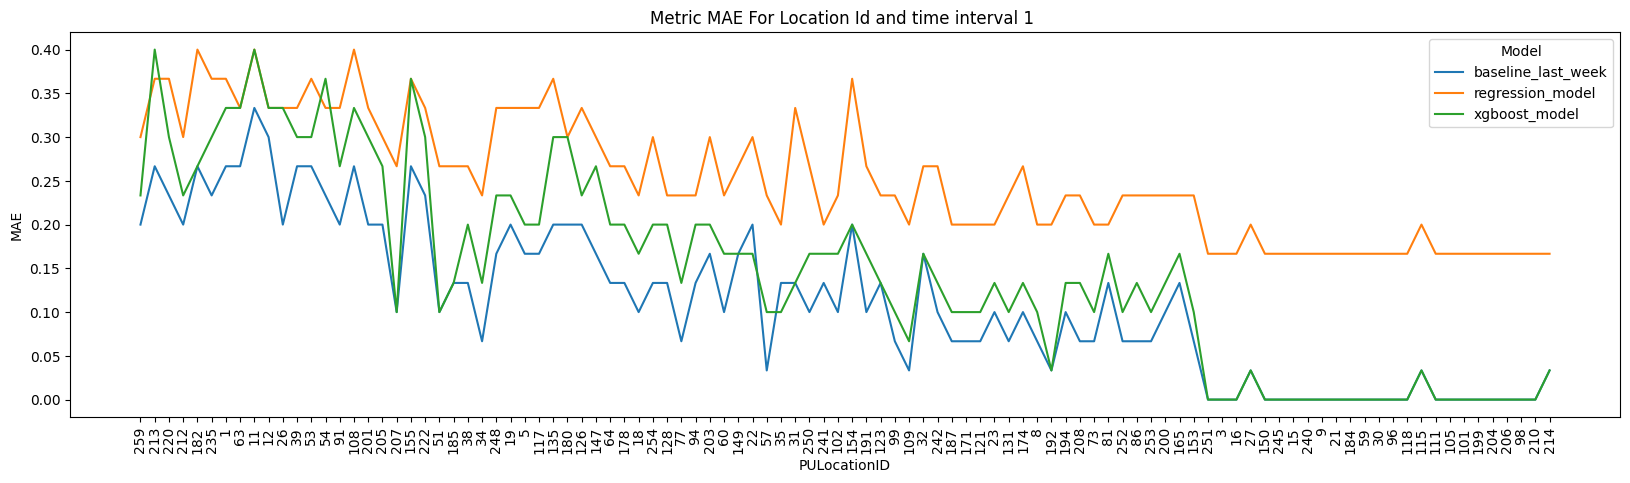

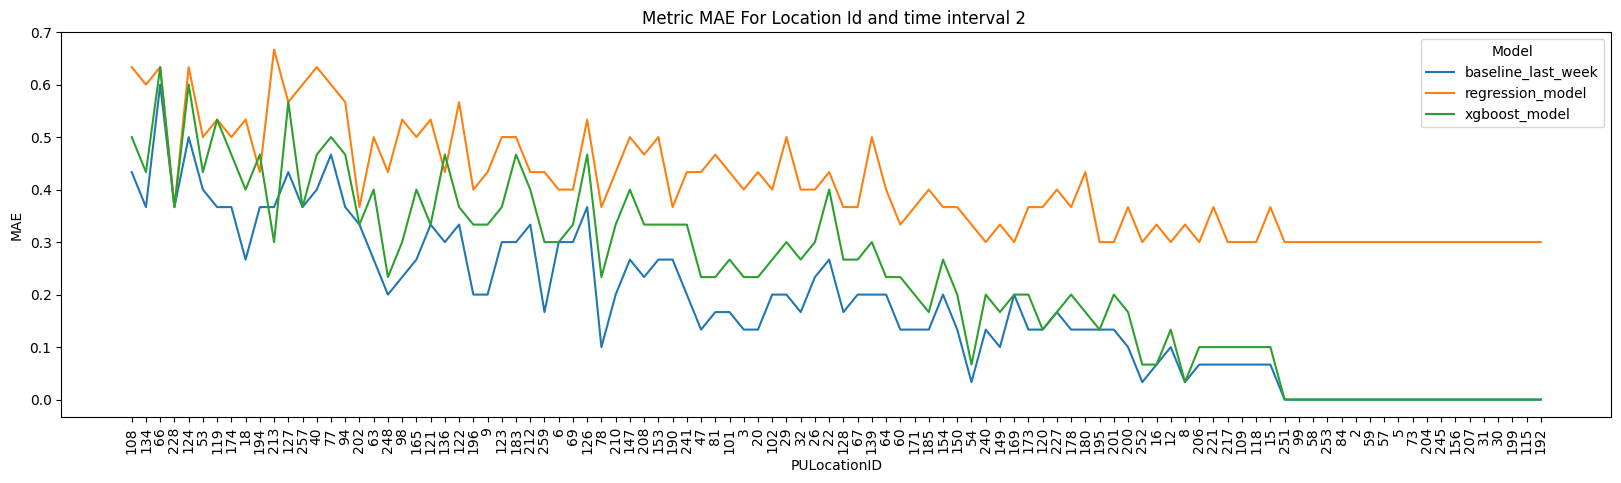

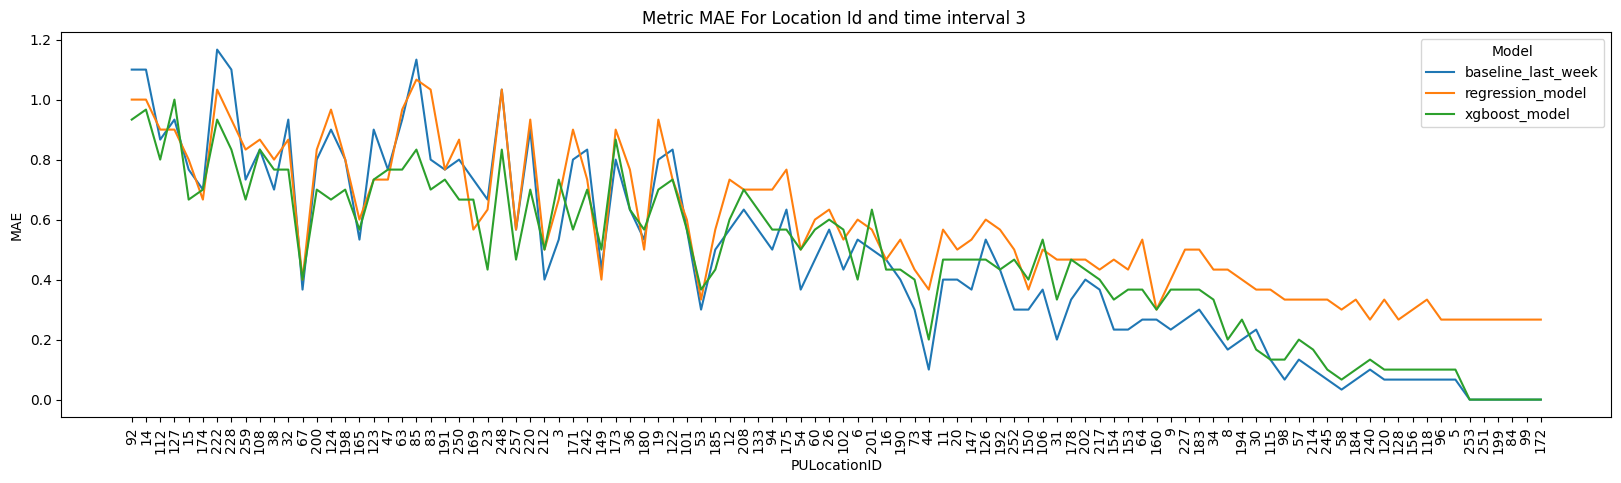

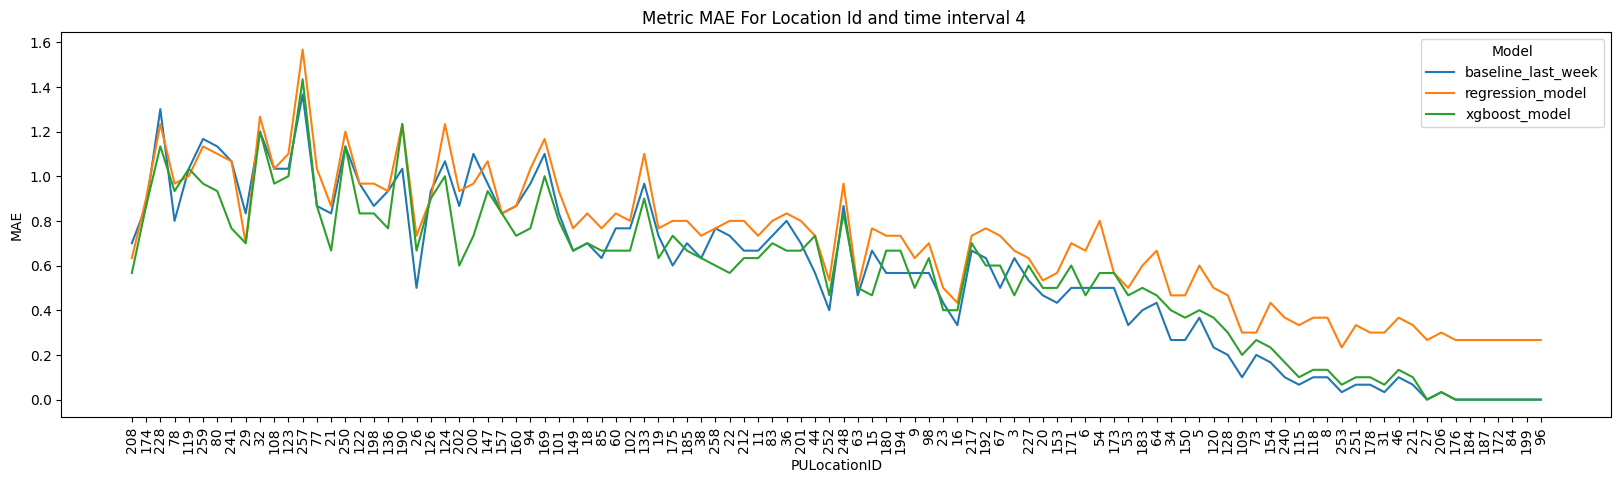

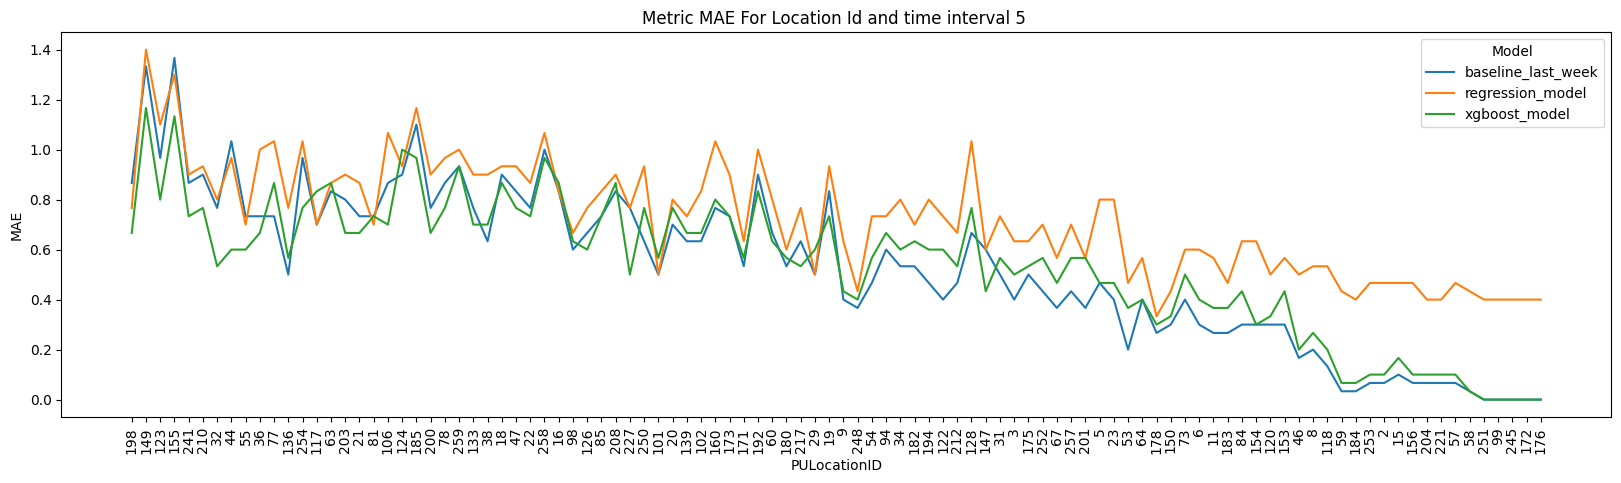

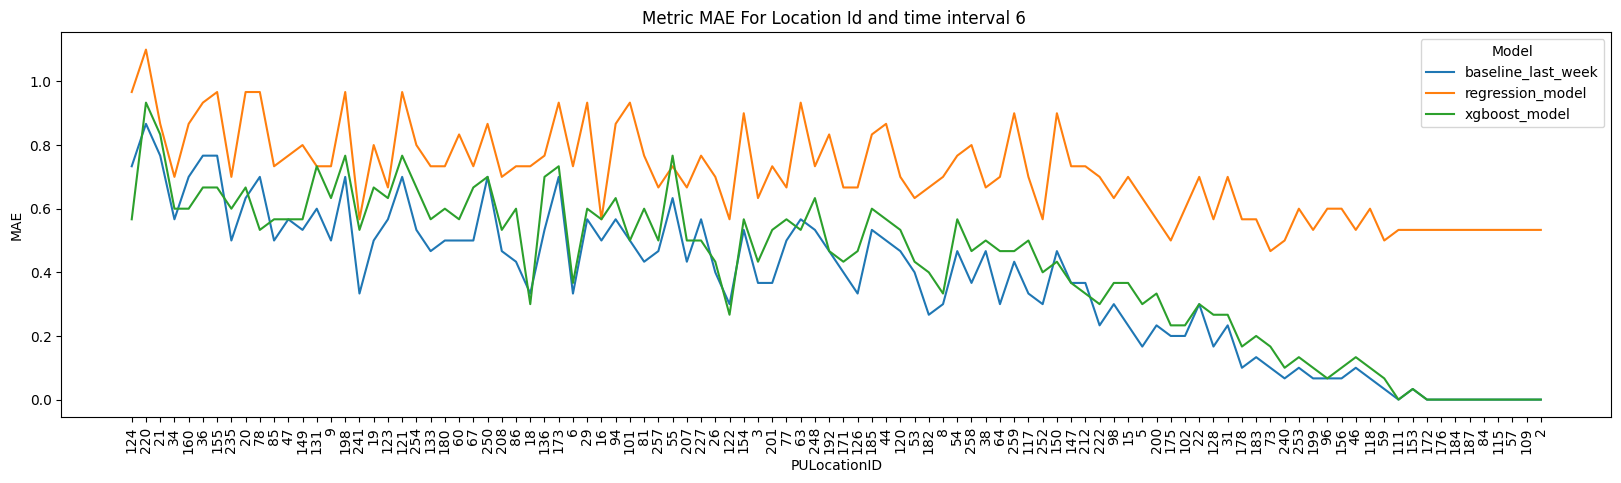

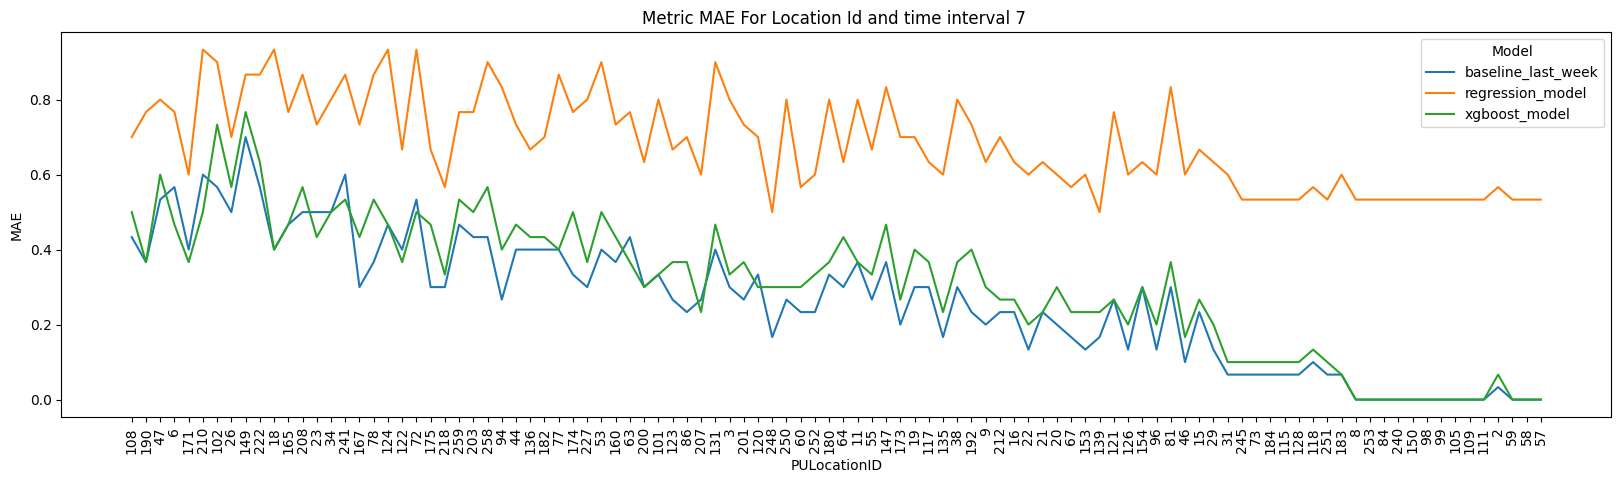

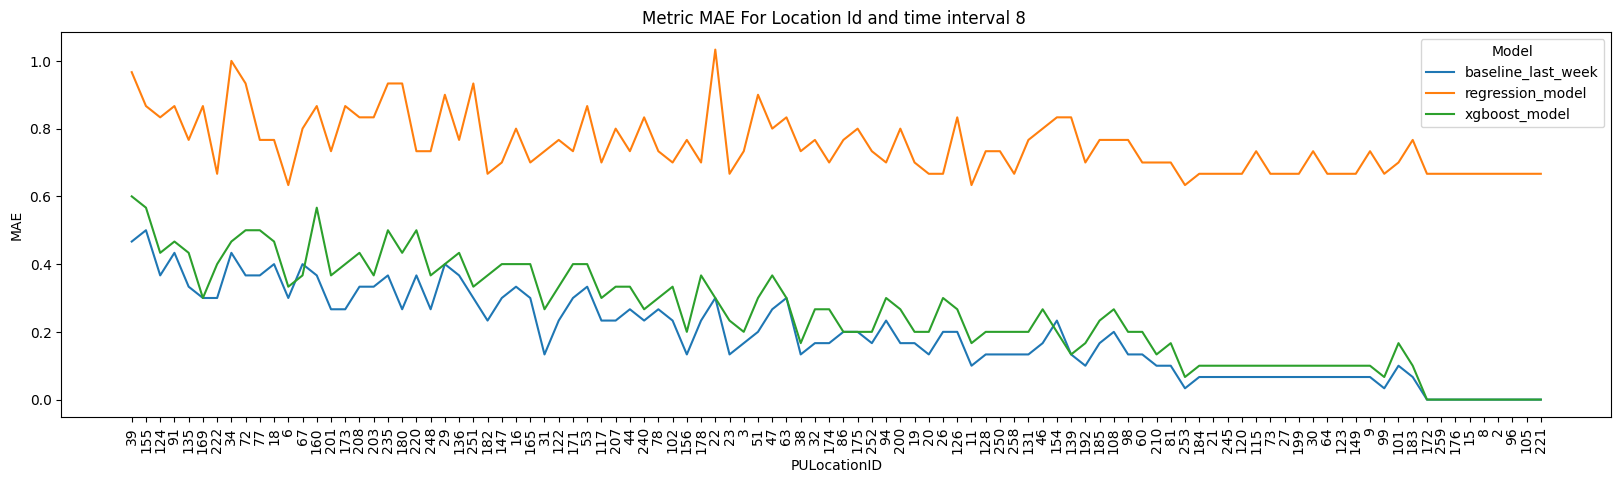

In [ ]:
for interval in range(1, 9):
    plot_model_metric(
        xgb_rides_df_sorted[interval],
        PULocationIDs_Metrics_sorted[interval],
        150,
        250,
        'MAE',
        interval
    )

## Compare Models prediction vs. Last day count based on actual count

In [ ]:
def plot_model_actual(actual_data, pred_dict, interval, lower_bound = 0, upper_bound = 262):
    selected_df_model = actual_data.groupby('PULocationID')[['real demand']].mean().sort_values(
        'real demand',
        ascending = False
    ).reset_index()

    selected_df_model = selected_df_model.iloc[lower_bound:upper_bound]

    plt.figure(figsize = (18, 5))
    plt.scatter(
        selected_df_model.index,
        selected_df_model['real demand'],
        label = "Actual",
        color = 'red',
        s = 15
    )
    for key in pred_dict:
        sorted_df = pd.merge(
            selected_df_model['PULocationID'],
            pred_dict[key],
            on = 'PULocationID',
            how = 'left'
        )
        sorted_df = sorted_df.groupby('PULocationID')[['predicted demand']].mean().sort_values(
            'predicted demand',
            ascending = False
        ).reset_index()
        plt.plot(
            selected_df_model.index,
            sorted_df['predicted demand'],
            label = key
        )

    plt.xticks(
        selected_df_model.index,
        selected_df_model['PULocationID'],
        rotation = 90
    )

    plt.legend()
    plt.xlabel('PULocationID')
    plt.ylabel('Counts')
    plt.title(f'Demand count compare models predictions vs. actual in time interval {interval}')

    plt.show()

In [ ]:
def plot_separated_demand(predictions_dict, xgb_rides_df, lower_bound, upper_bound):
  for interval in range(1, 9):
      temp = {
        'baseline_last_week' : pd.DataFrame(),
        'regression_model' : pd.DataFrame(),
        'xgboost_model' : pd.DataFrame()
      }
      for key in predictions_dict.keys():
        temp[key] = temp[key].append(predictions_dict[key][predictions_dict[key]['time_interval_number'] == interval])
      plot_model_actual(
          xgb_rides_df[xgb_rides_df['time_interval_number'] == interval],
          temp,
          interval,
          lower_bound,
          upper_bound
      )

### High Demand

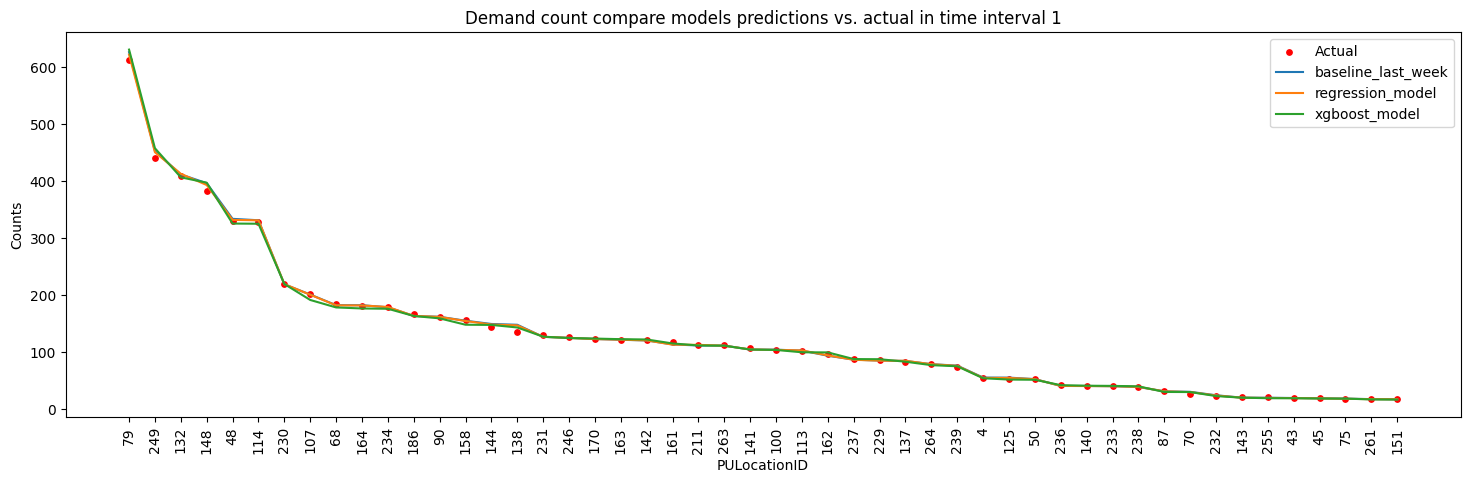

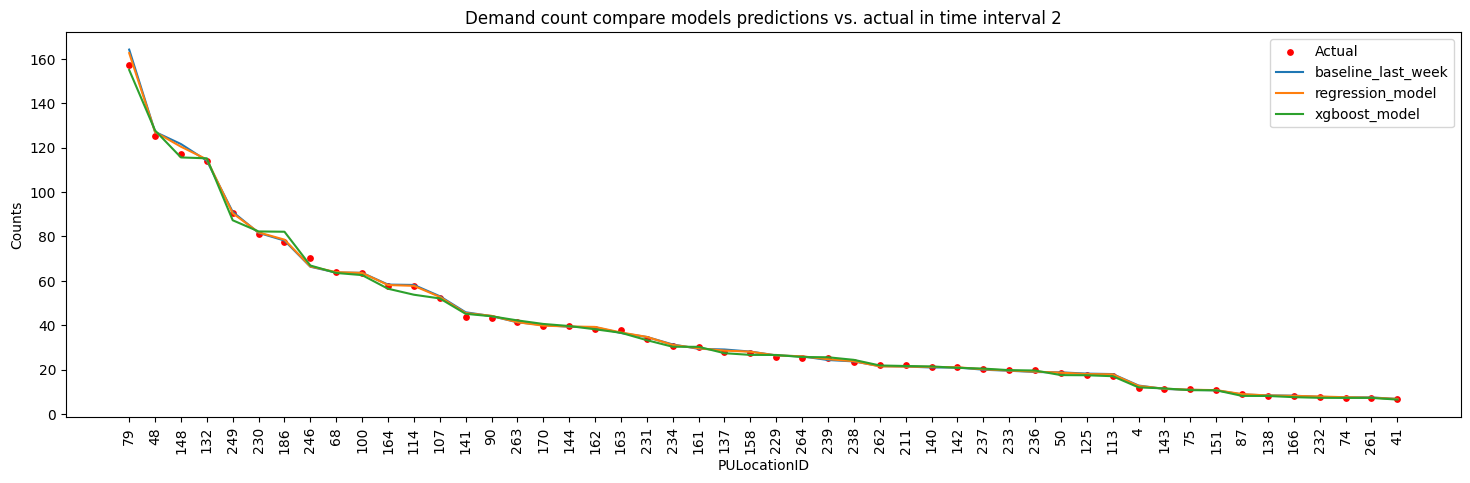

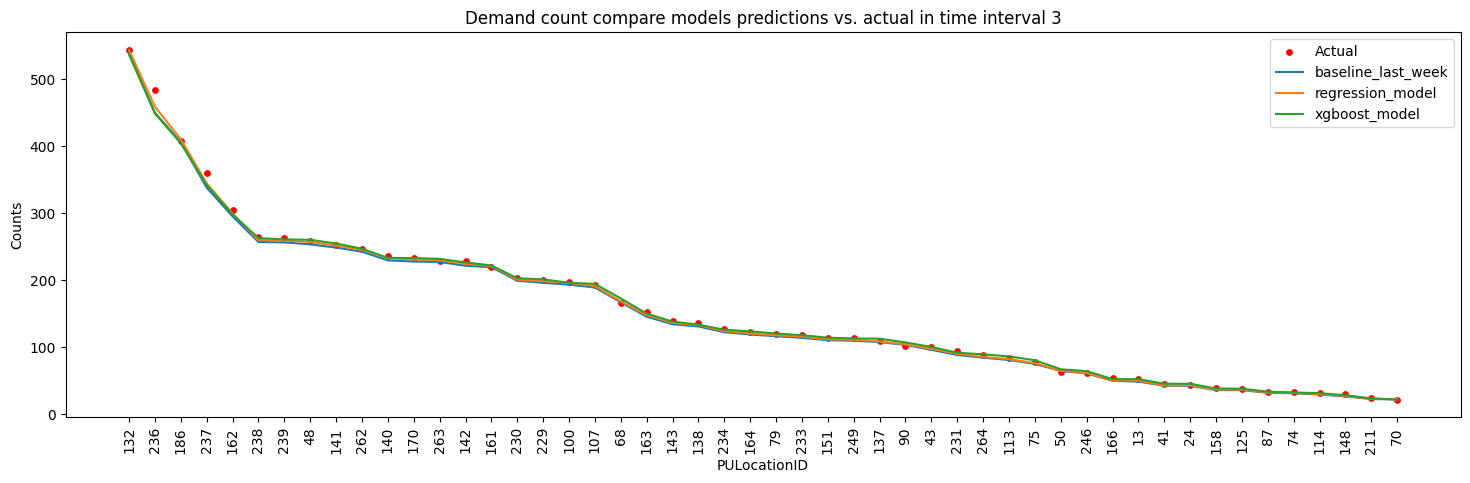

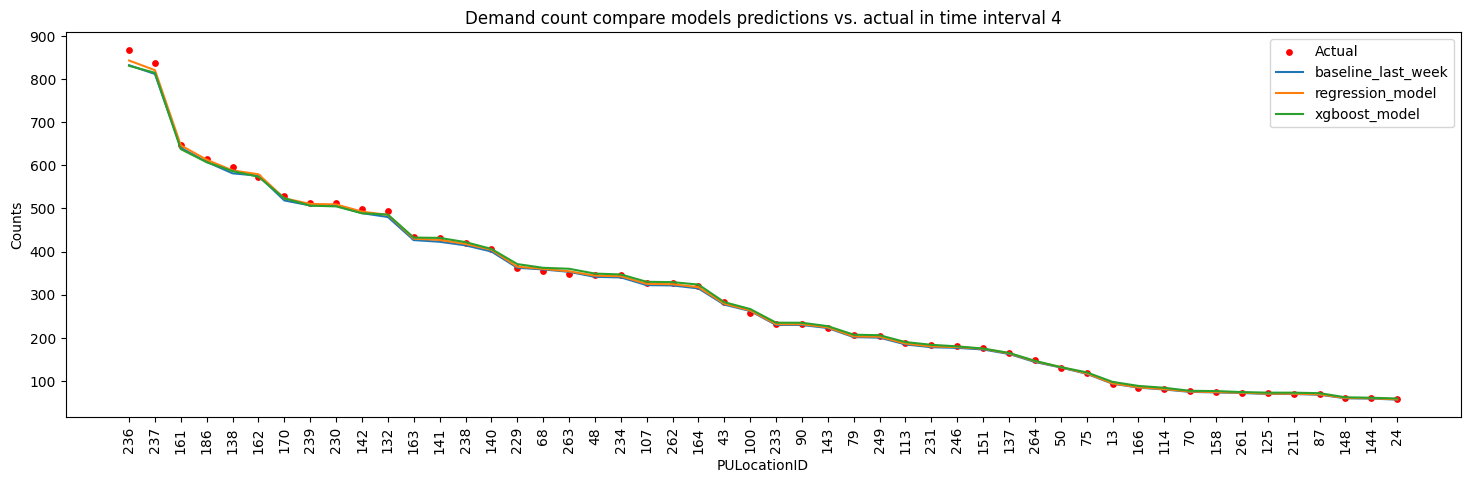

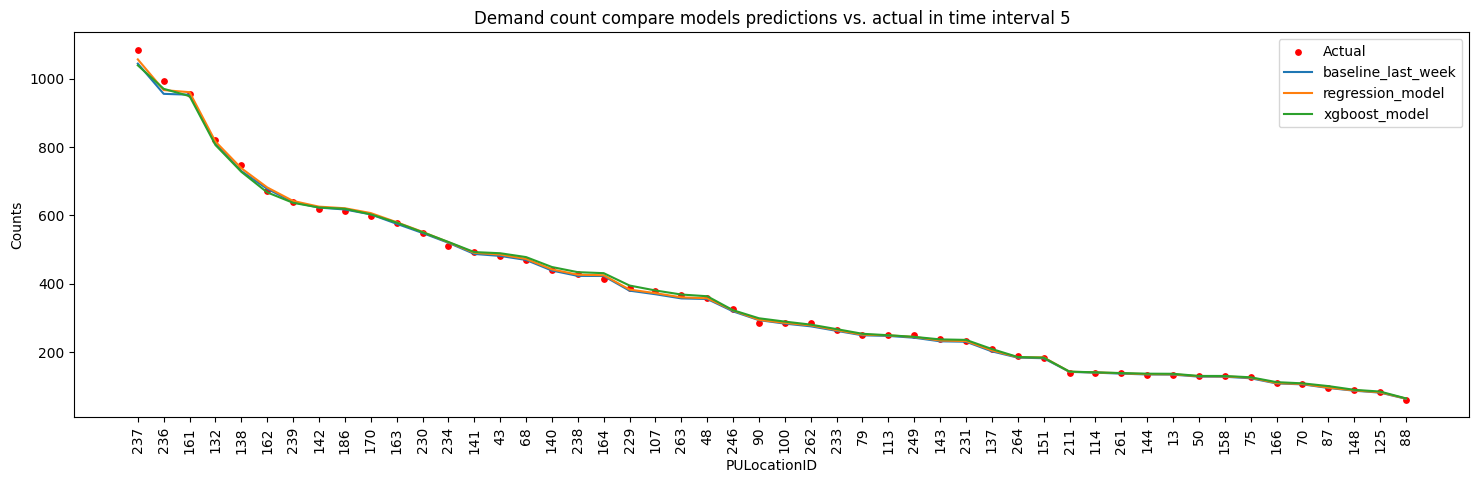

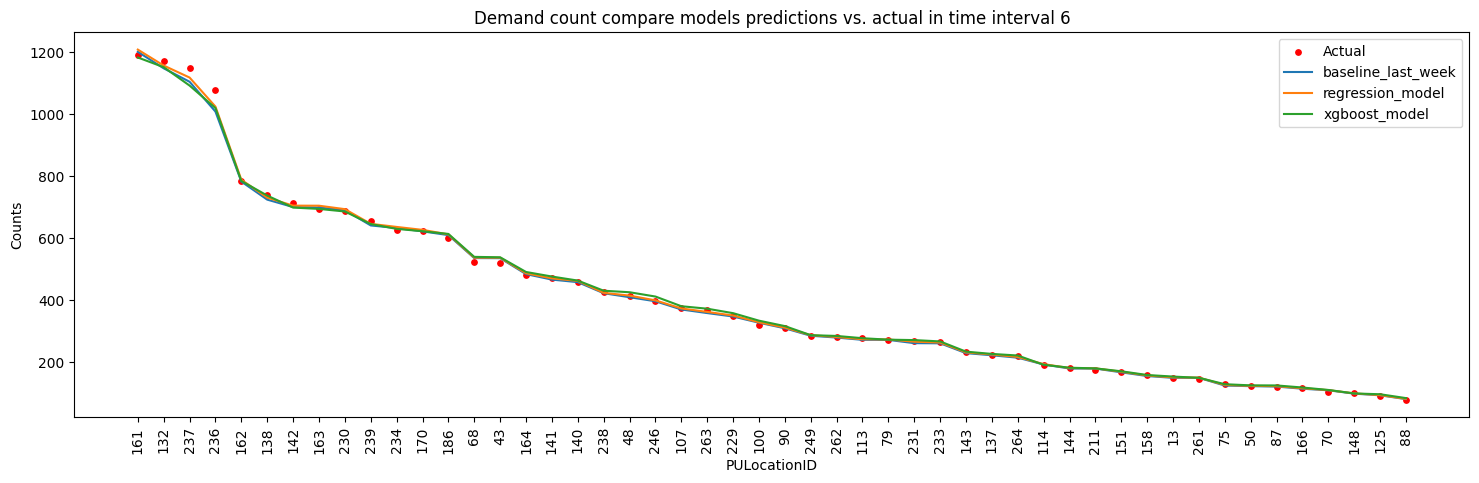

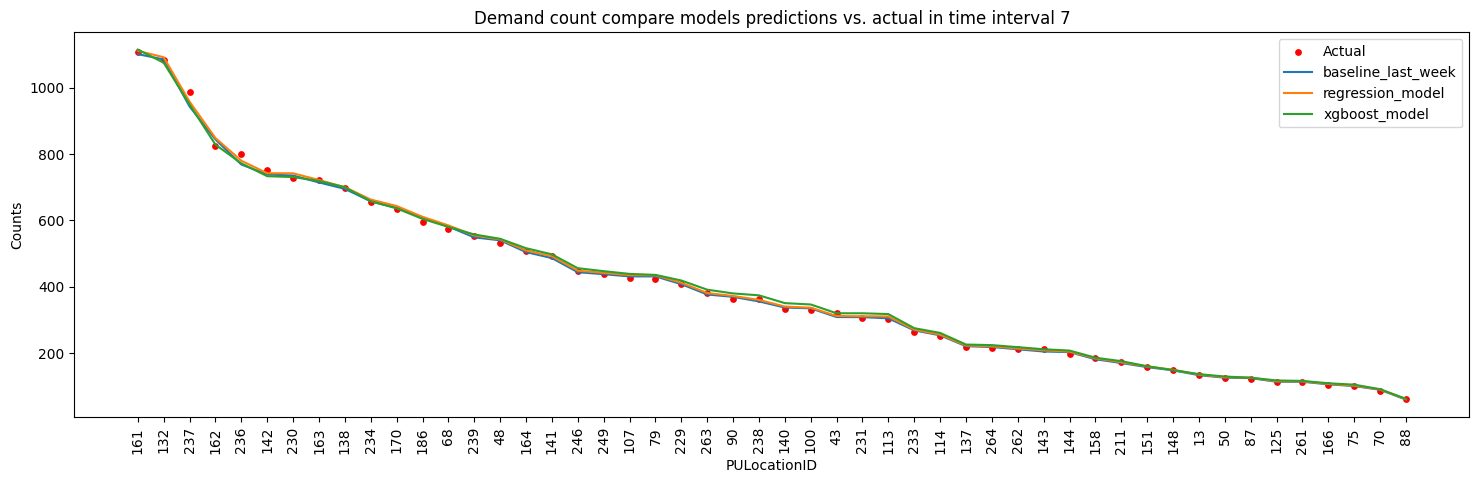

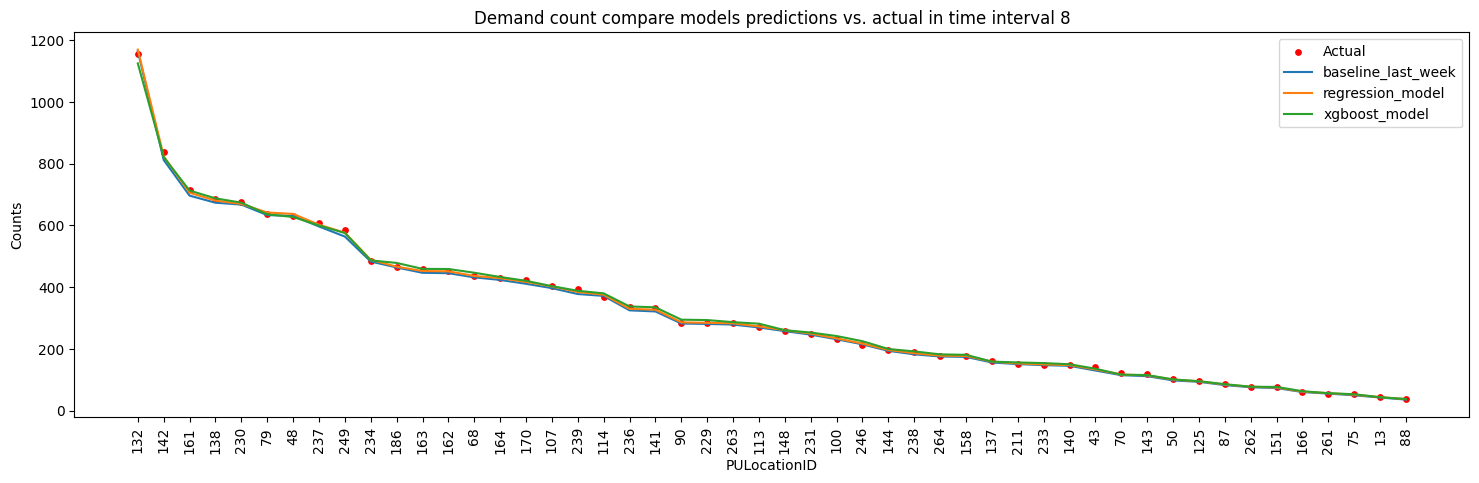

In [ ]:
plot_separated_demand(predictions_dict, xgb_rides_df, 0, 50)

### Mid Demand

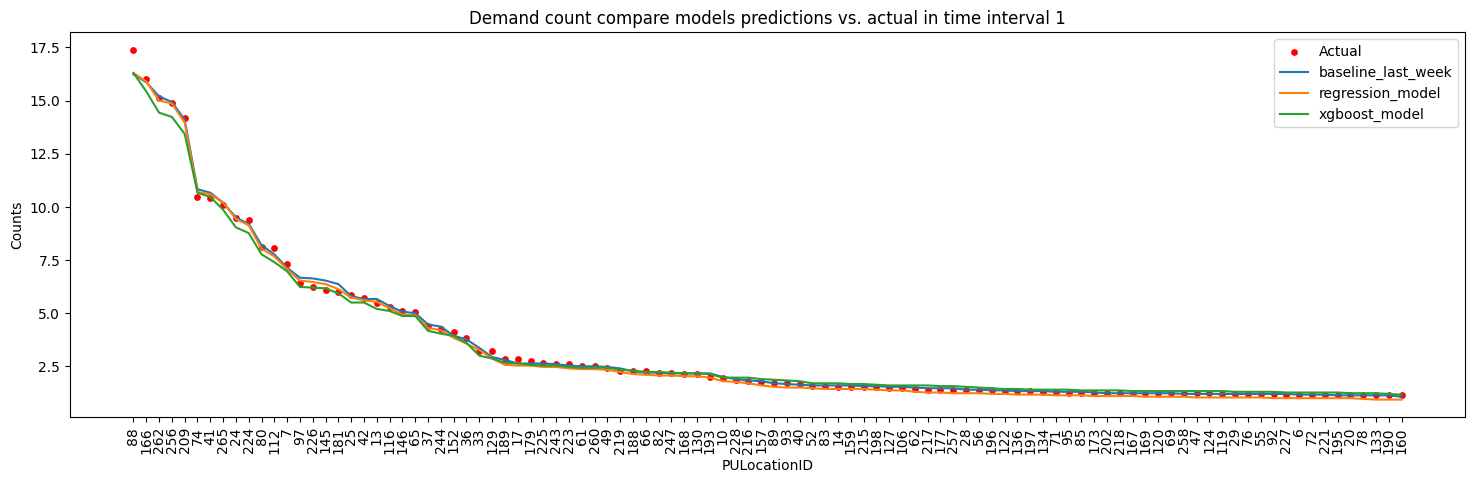

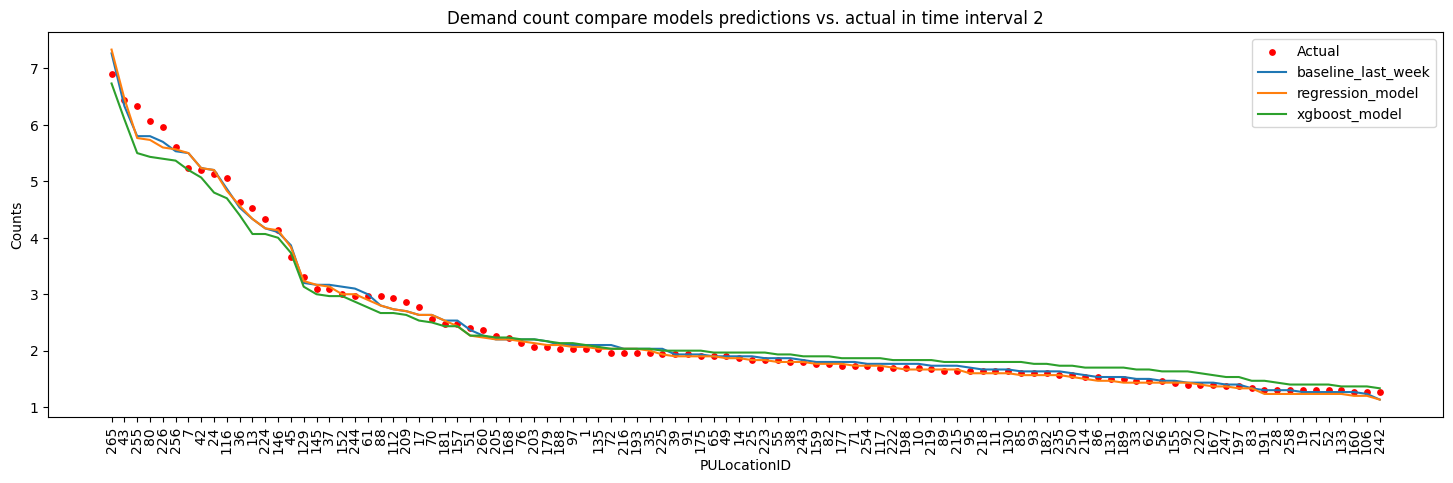

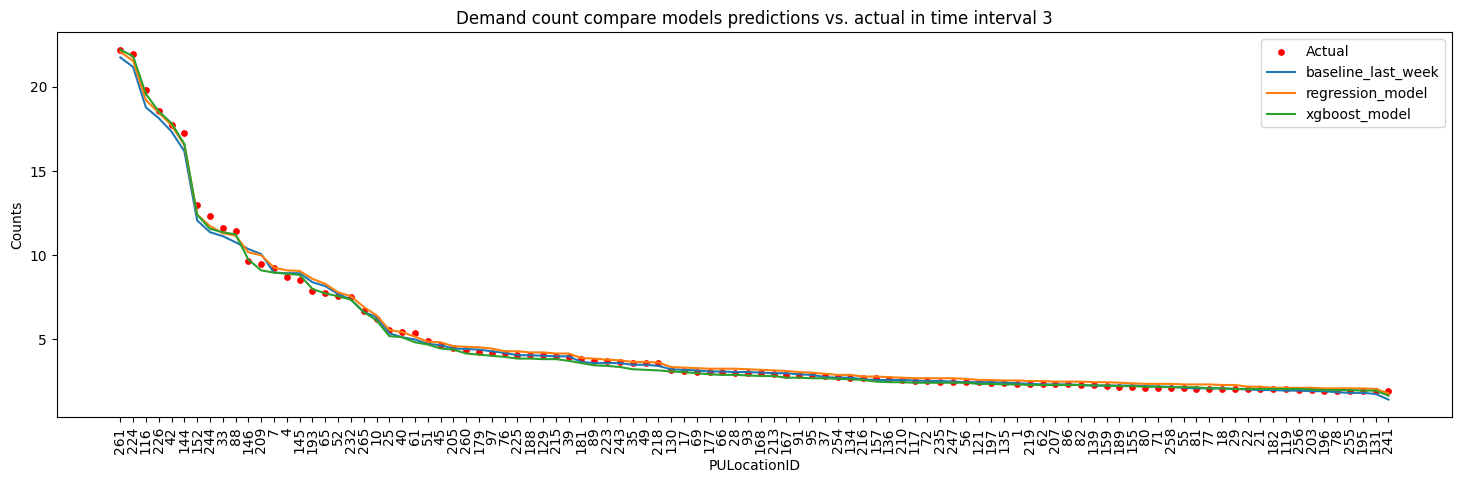

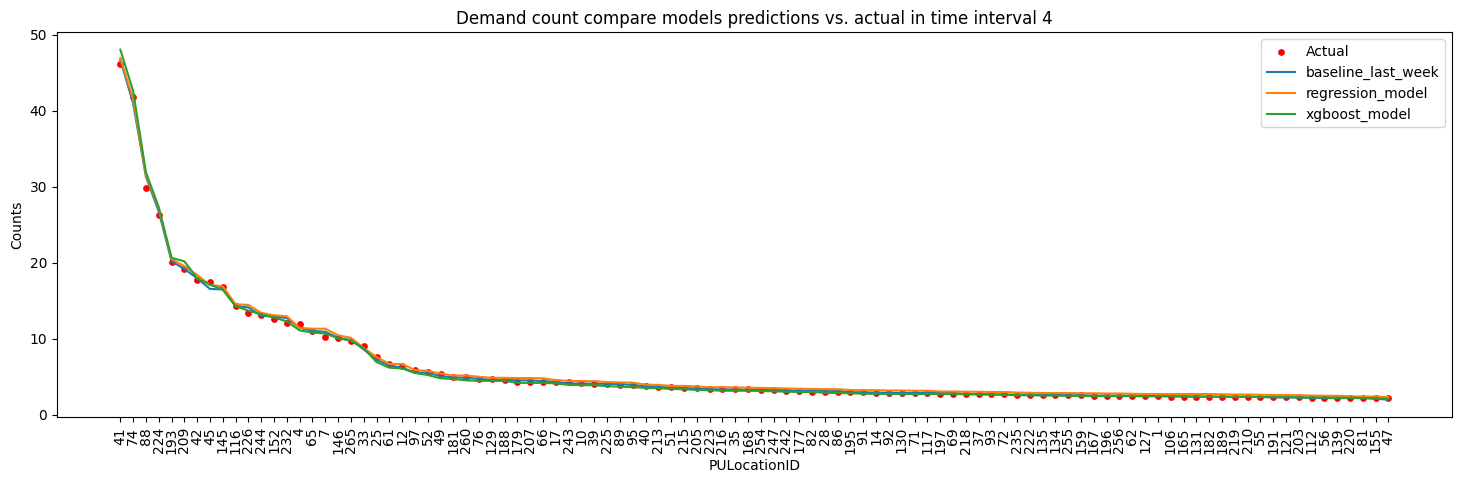

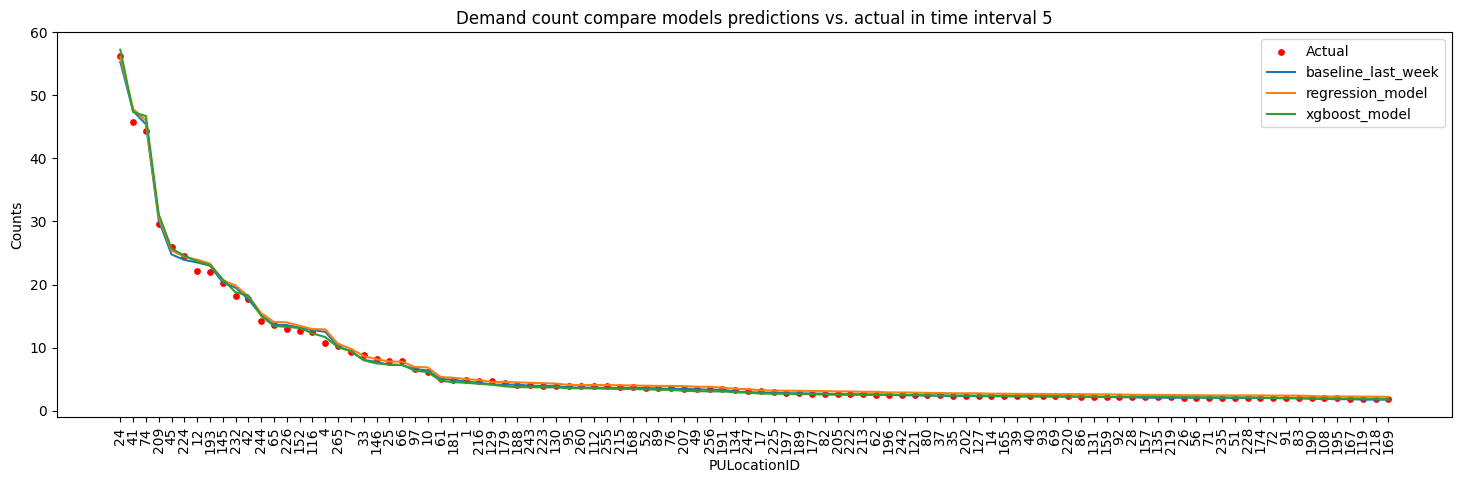

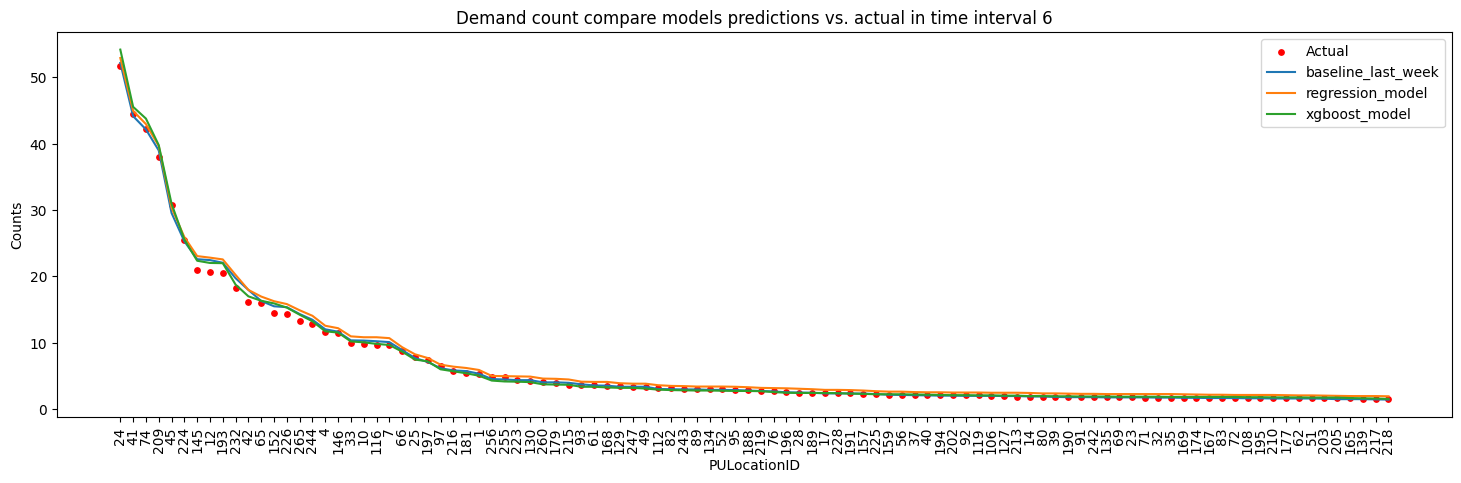

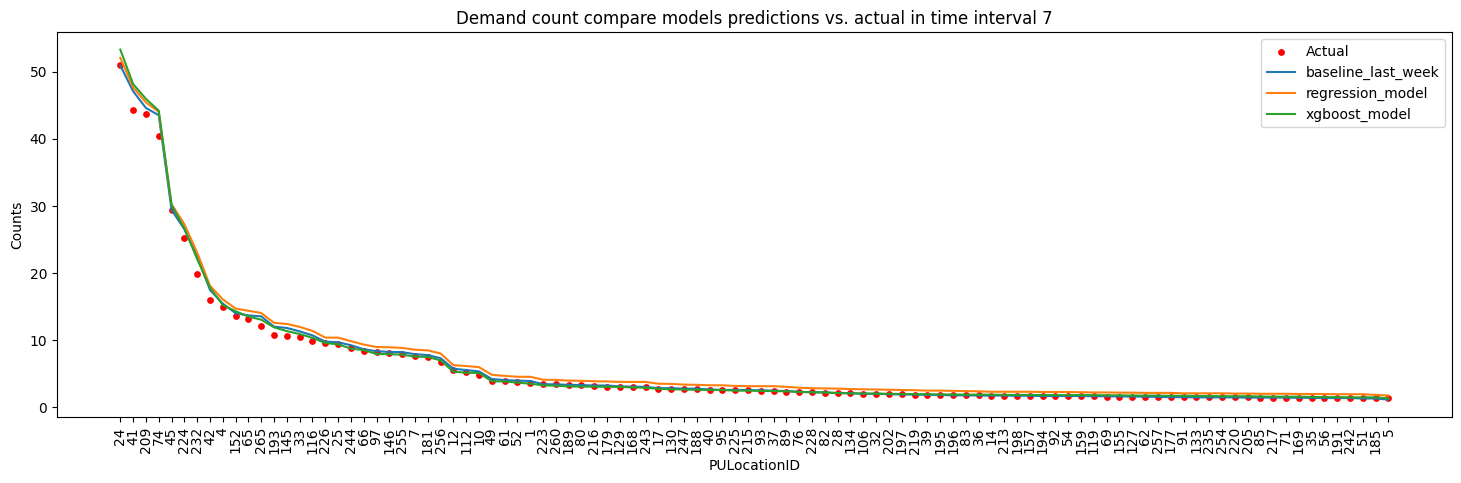

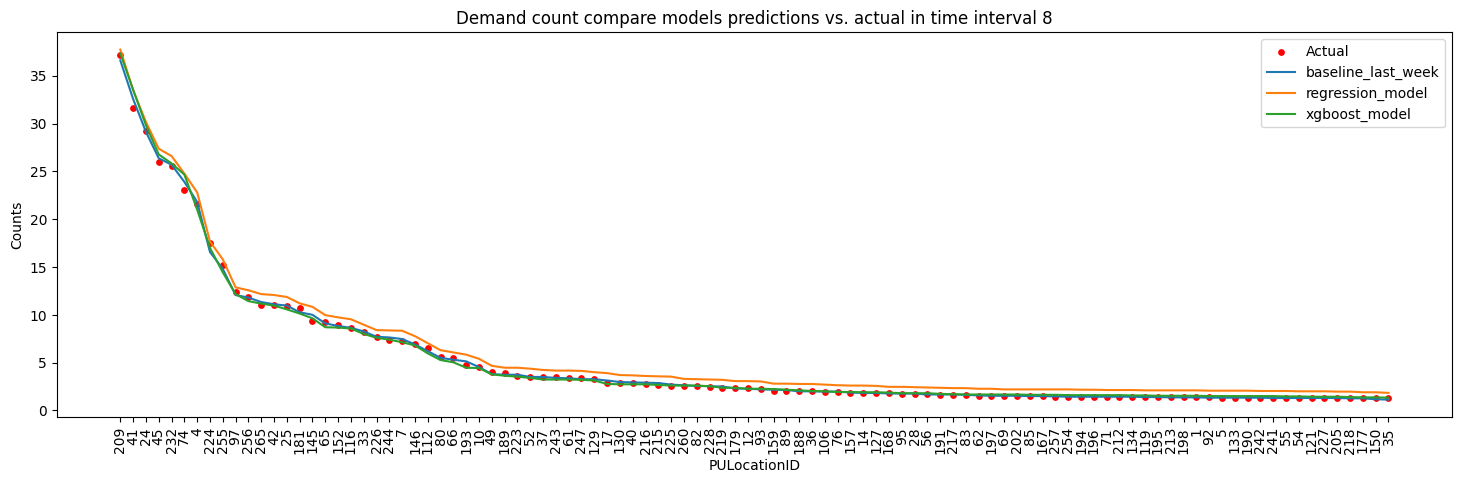

In [ ]:
plot_separated_demand(predictions_dict, xgb_rides_df, 50, 150)

### Low Demand

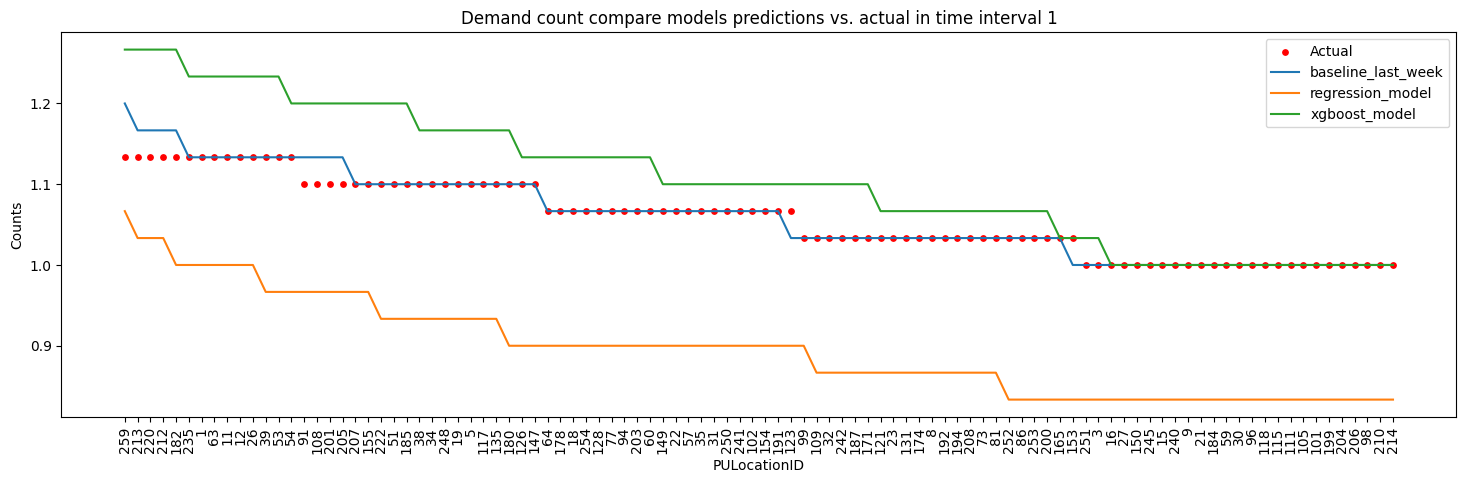

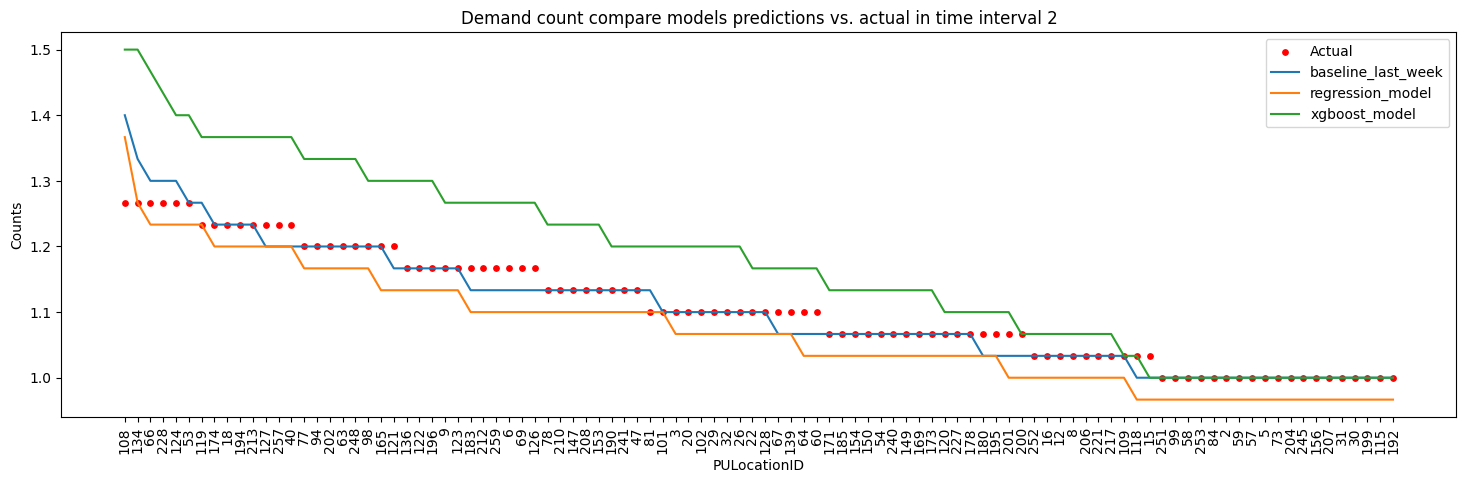

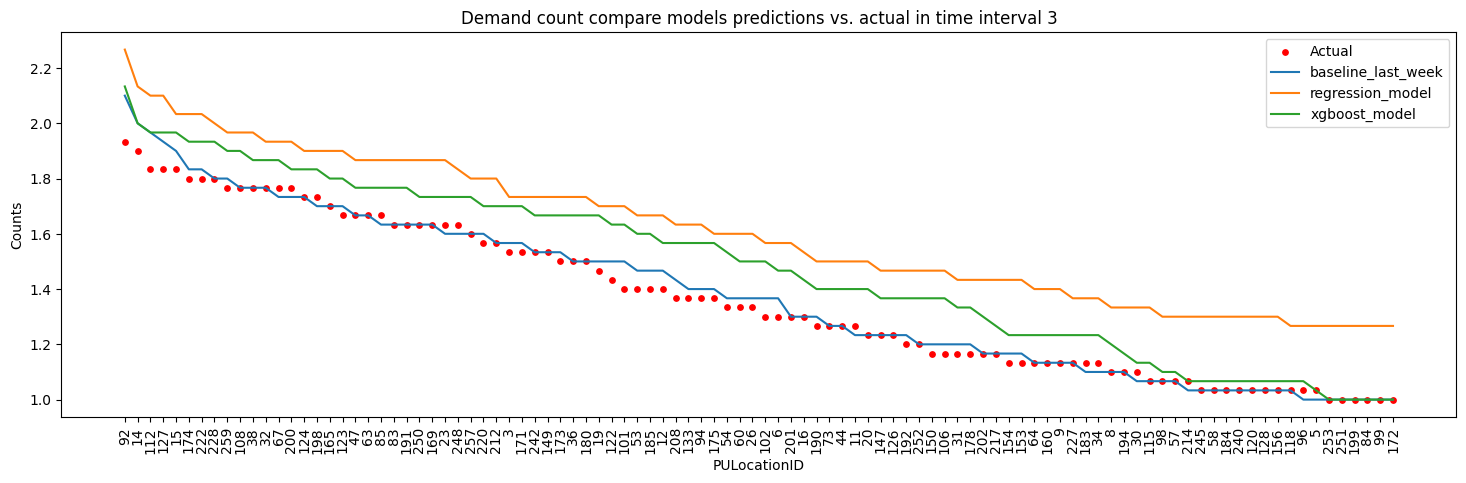

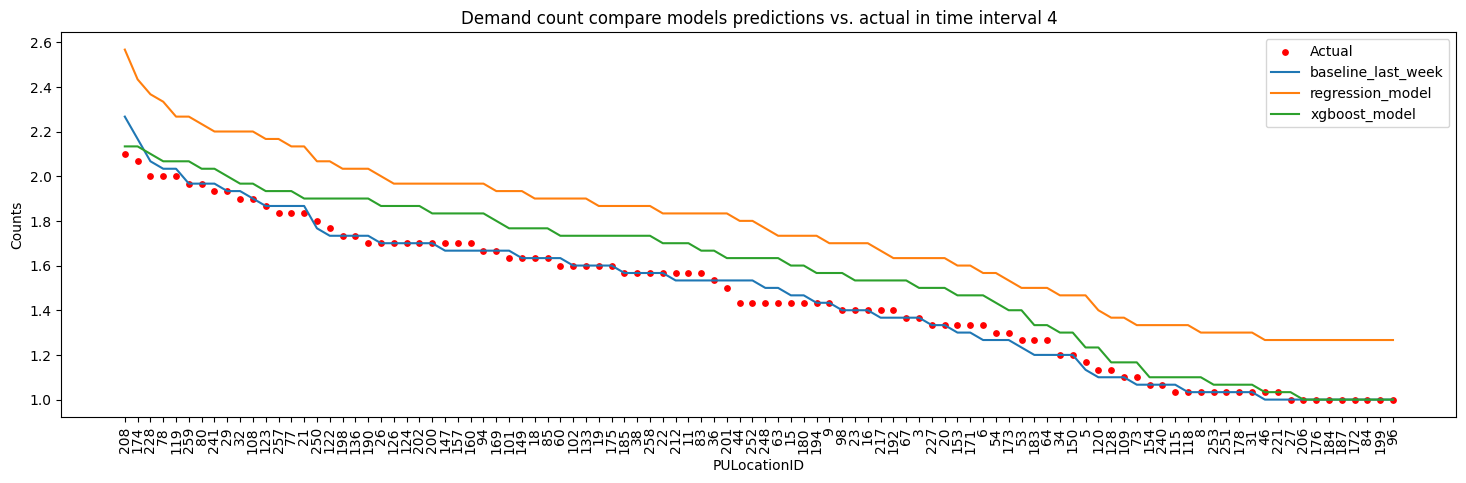

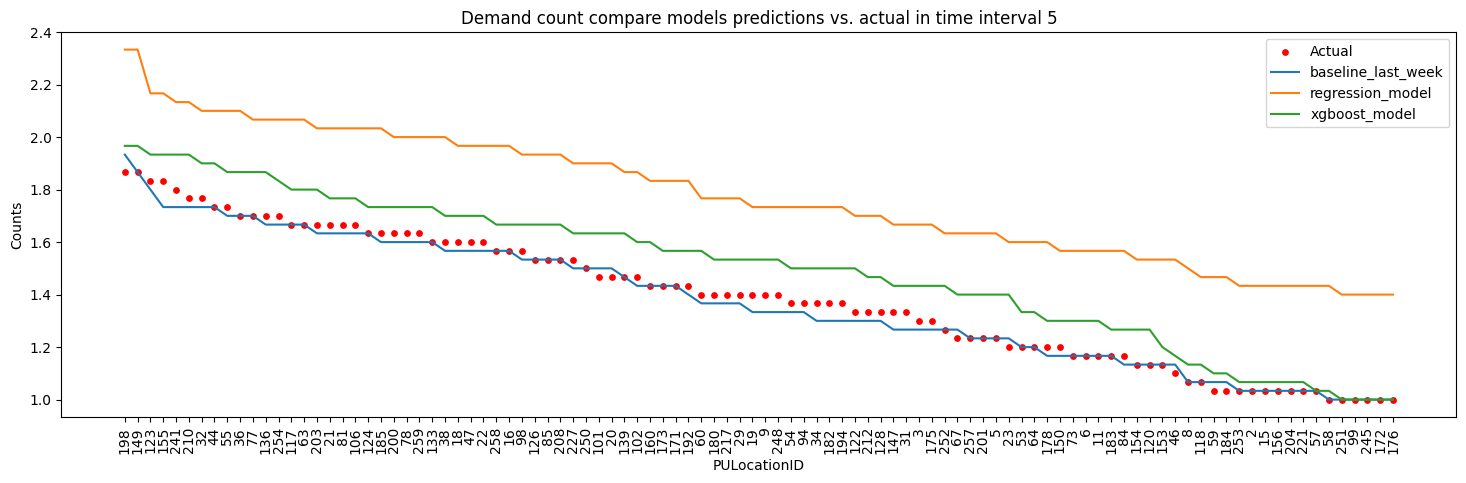

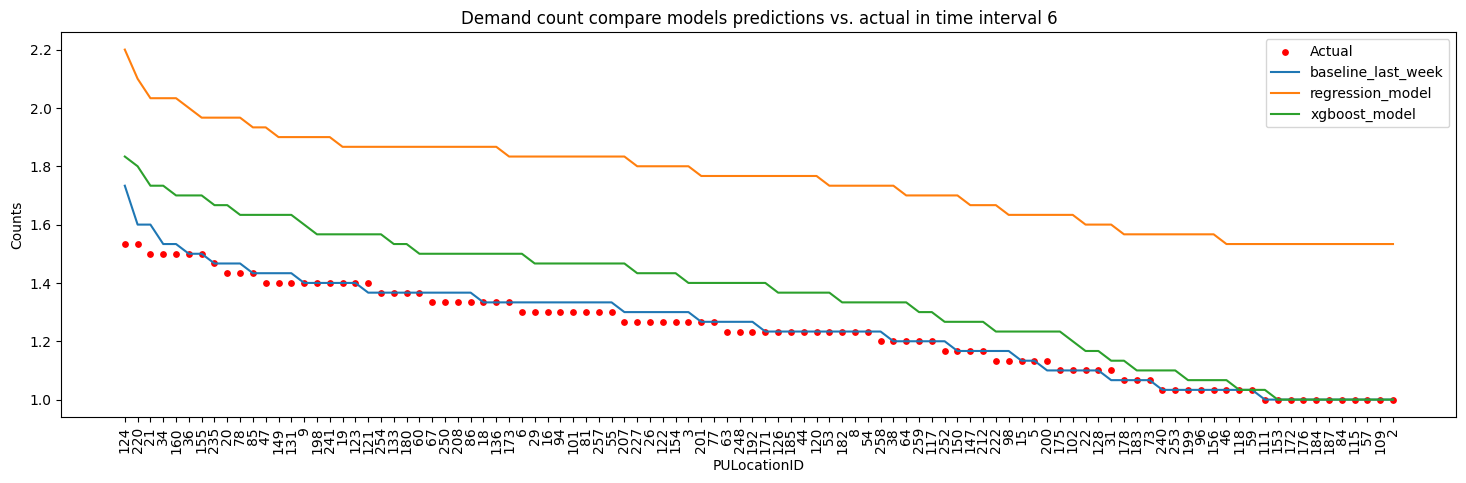

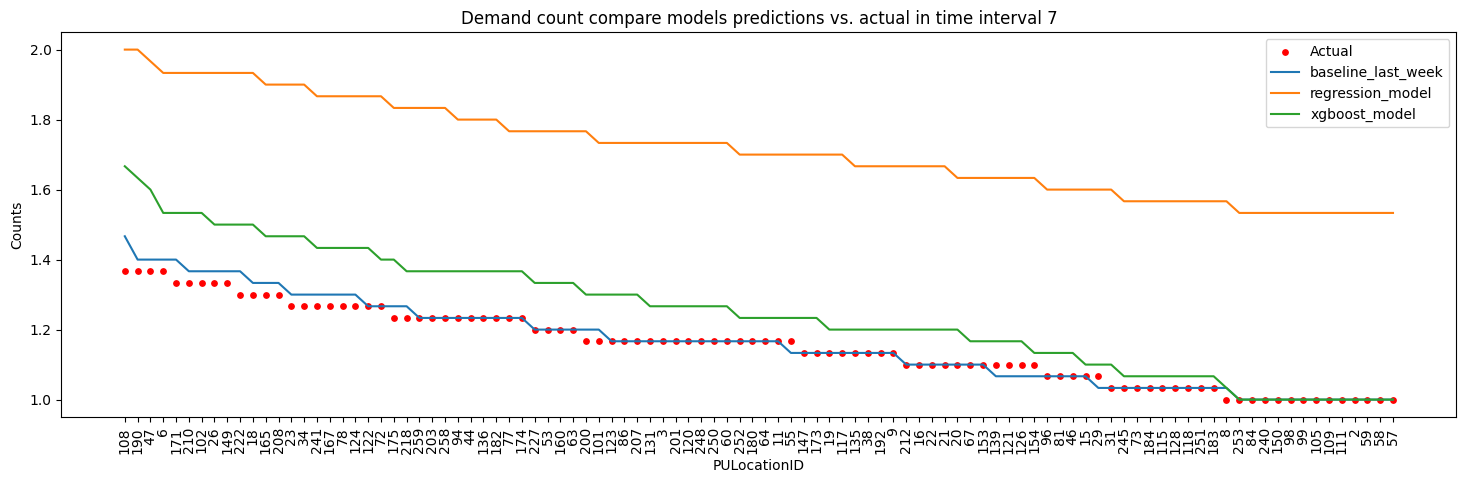

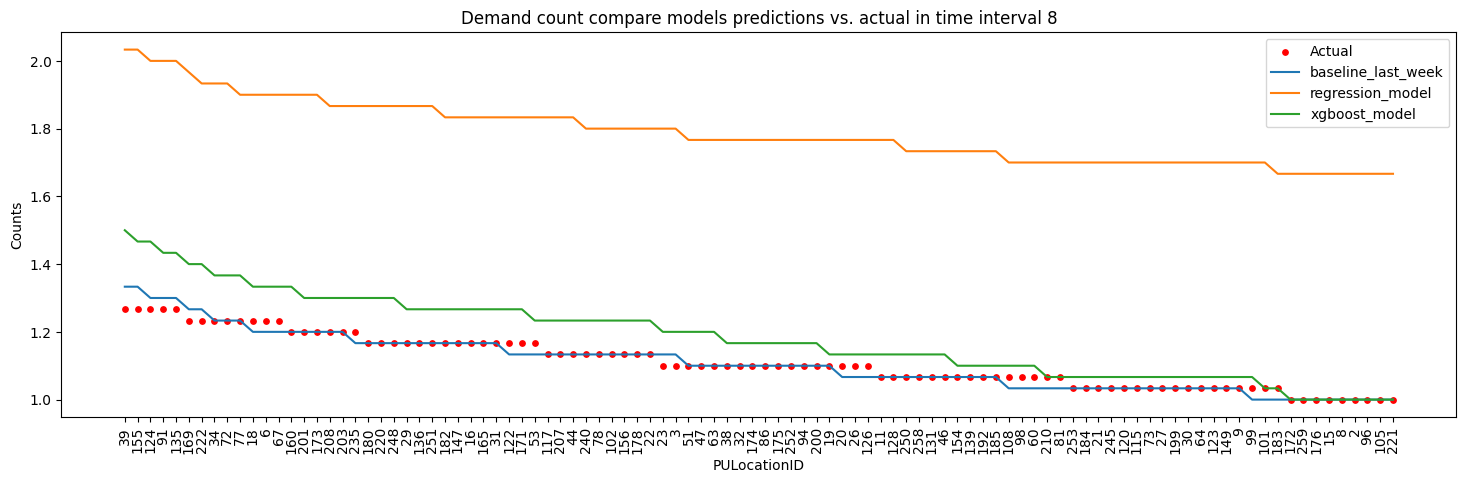

In [ ]:
plot_separated_demand(predictions_dict, xgb_rides_df, 150, 250)

# Model prediction results in metrics

Metrics: MAPE, MAE, RMSE

In [ ]:
def calculate_metrics(df, sorted_df, lower = 0, upper = 266):
    PULocationIDs_Metrics_Selected = sorted_df[
        sorted_df['PULocationID'].isin(df.iloc[lower:upper, 0])
    ]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected['PULocationID'].astype('str')
    predictions_result = []
    for key in predictions_dict:
        metric_mape = PULocationIDs_Metrics_Selected[
            PULocationIDs_Metrics_Selected['Model'] == key
        ]['MAPE'].mean()
        metric_mae = PULocationIDs_Metrics_Selected[
            PULocationIDs_Metrics_Selected['Model'] == key
        ]['MAE'].mean()
        metric_rmse = PULocationIDs_Metrics_Selected[
            PULocationIDs_Metrics_Selected['Model'] == key
        ]['RMSE'].mean()
        predictions_result.append(
            {
                'Model' : key,
                f"MAPE_{lower}-{upper}" : metric_mape,
                f"MAE_{lower}-{upper}" : metric_mae,
                f"RMSE_{lower}-{upper}" : metric_rmse
            }
        )
    return predictions_result

In [ ]:
high_demand_df = {}
mid_demand_df = {}
low_demand_df = {}

def split_by_demand(lower_bound, upper_bound,interval):
  df = pd.DataFrame()
  df = df.append(
    pd.DataFrame(
        calculate_metrics(
            xgb_rides_df_sorted[interval],
            PULocationIDs_Metrics_sorted[interval],
            lower_bound,
            upper_bound
        )
    )
  )
  return df

for interval in range(1, 9):
    high_demand_df[interval] = split_by_demand(0, 50, interval)
    mid_demand_df[interval] = split_by_demand(50, 150, interval)
    low_demand_df[interval] = split_by_demand(150, 250, interval)

In [ ]:
high_demand_df[4]

Model  MAPE_0-50   MAE_0-50  RMSE_0-50
0  baseline_last_week   0.122617  31.905333  39.664575
1    regression_model   0.113420  29.325333  36.691275
2       xgboost_model   0.112004  28.238000  35.564891

Merging all the results together and sort them

In [ ]:
merged_result_df = {}
for interval in range(1, 9):
    merged_result_df[interval] = high_demand_df[interval].merge(
        mid_demand_df[interval],
        on = 'Model'
    ).merge(
        low_demand_df[interval],
        on = 'Model'
    )

In [ ]:
for interval in range(1, 9):
    display(f"interval: {interval}",merged_result_df[interval])

'interval: 1'

Model  MAPE_0-50   MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.323490  30.442000  45.911042     0.476419   
1    regression_model   0.423459  31.082667  43.949263     0.517358   
2       xgboost_model   0.334204  26.720000  39.291433     0.493143   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    1.523000     2.221023      0.084556     0.113333      0.303987  
1    1.539667     2.183436      0.217667     0.252667      0.529499  
2    1.435000     2.007316      0.122722     0.148667      0.337599

'interval: 2'

Model  MAPE_0-50  MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.335849  9.334000  13.148099     0.515301   
1    regression_model   0.403025  9.396000  12.759587     0.585929   
2       xgboost_model   0.350793  8.740667  12.072236     0.514618   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    1.126667     1.623122      0.131444     0.181667      0.400094  
1    1.182667     1.629919      0.358056     0.408000      0.672917  
2    1.030333     1.441624      0.192667     0.237000      0.439151

'interval: 3'

Model  MAPE_0-50   MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.183387  23.111333  29.739319     0.575691   
1    regression_model   0.176811  21.733333  28.324655     0.570224   
2       xgboost_model   0.179276  21.280000  27.894891     0.529781   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    2.038667     2.710098      0.317439     0.474667      0.763304  
1    1.938667     2.561631      0.450417     0.581667      0.884117  
2    1.829000     2.391280      0.355717     0.472667      0.710871

'interval: 4'

Model  MAPE_0-50   MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.122617  31.905333  39.664575     0.594248   
1    regression_model   0.113420  29.325333  36.691275     0.616367   
2       xgboost_model   0.112004  28.238000  35.564891     0.525889   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    2.446333     3.268323      0.372521     0.580333      0.902268  
1    2.351333     3.117705      0.534579     0.709333      1.040793  
2    2.176000     2.873470      0.408910     0.567333      0.819930

'interval: 5'

Model  MAPE_0-50   MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.114408  36.934000  46.111106     0.596109   
1    regression_model   0.106475  34.024667  42.765956     0.656524   
2       xgboost_model   0.104932  32.952000  41.501575     0.537576   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    2.537667     3.316909      0.357411     0.536000      0.838024  
1    2.475000     3.197487      0.591422     0.724333      1.028734  
2    2.260667     2.939952      0.404489     0.541000      0.778152

'interval: 6'

Model  MAPE_0-50   MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.131408  46.022000  57.520645     0.562959   
1    regression_model   0.123266  42.619333  53.121388     0.658137   
2       xgboost_model   0.121814  42.364000  52.659330     0.511674   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    2.563667     3.433023      0.268956     0.374667      0.644611  
1    2.508667     3.305887      0.640678     0.711000      0.968534  
2    2.268333     2.977359      0.336967     0.423000      0.636809

'interval: 7'

Model  MAPE_0-50   MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.165961  58.655333  73.374673     0.573641   
1    regression_model   0.158516  54.804667  68.042744     0.749417   
2       xgboost_model   0.155384  52.542667  65.221889     0.530284   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    2.489000     3.268993      0.191667        0.266      0.537327  
1    2.519667     3.236466      0.643211        0.686      0.946304  
2    2.188000     2.841018      0.248461        0.309      0.542831

'interval: 8'

Model  MAPE_0-50   MAE_0-50  RMSE_0-50  MAPE_50-150  \
0  baseline_last_week   0.195925  53.370667  69.090997     0.540384   
1    regression_model   0.200491  52.044667  66.430593     0.771509   
2       xgboost_model   0.191296  48.951333  62.964967     0.511261   

   MAE_50-150  RMSE_50-150  MAPE_150-250  MAE_150-250  RMSE_150-250  
0    2.166667     2.916264      0.140283     0.195667      0.455274  
1    2.263000     2.931474      0.725983     0.753000      0.950352  
2    1.914333     2.549862      0.204339     0.255000      0.497294

Defining a custom sorting function to extract the numeric suffix and sort the columns accordingly

In [ ]:
def sort_columns_key(column):
    if column == 'Model':
        return (0, '')
    metric, suffix = column.split('_')
    return (
        1,
        metric,
        int(suffix.split('-')[0]),
        int(suffix.split('-')[1])
    )

for interval in range(1, 9):
    sorted_columns = sorted(
        merged_result_df[interval].columns,
        key = sort_columns_key
    )
    predictions_result = merged_result_df[interval][sorted_columns]
    display(f"interval: {interval}",predictions_result)

'interval: 1'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  30.442000    1.523000     0.113333   0.323490   
1    regression_model  31.082667    1.539667     0.252667   0.423459   
2       xgboost_model  26.720000    1.435000     0.148667   0.334204   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.476419      0.084556  45.911042     2.221023      0.303987  
1     0.517358      0.217667  43.949263     2.183436      0.529499  
2     0.493143      0.122722  39.291433     2.007316      0.337599

'interval: 2'

Model  MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  9.334000    1.126667     0.181667   0.335849   
1    regression_model  9.396000    1.182667     0.408000   0.403025   
2       xgboost_model  8.740667    1.030333     0.237000   0.350793   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.515301      0.131444  13.148099     1.623122      0.400094  
1     0.585929      0.358056  12.759587     1.629919      0.672917  
2     0.514618      0.192667  12.072236     1.441624      0.439151

'interval: 3'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  23.111333    2.038667     0.474667   0.183387   
1    regression_model  21.733333    1.938667     0.581667   0.176811   
2       xgboost_model  21.280000    1.829000     0.472667   0.179276   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.575691      0.317439  29.739319     2.710098      0.763304  
1     0.570224      0.450417  28.324655     2.561631      0.884117  
2     0.529781      0.355717  27.894891     2.391280      0.710871

'interval: 4'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  31.905333    2.446333     0.580333   0.122617   
1    regression_model  29.325333    2.351333     0.709333   0.113420   
2       xgboost_model  28.238000    2.176000     0.567333   0.112004   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.594248      0.372521  39.664575     3.268323      0.902268  
1     0.616367      0.534579  36.691275     3.117705      1.040793  
2     0.525889      0.408910  35.564891     2.873470      0.819930

'interval: 5'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  36.934000    2.537667     0.536000   0.114408   
1    regression_model  34.024667    2.475000     0.724333   0.106475   
2       xgboost_model  32.952000    2.260667     0.541000   0.104932   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.596109      0.357411  46.111106     3.316909      0.838024  
1     0.656524      0.591422  42.765956     3.197487      1.028734  
2     0.537576      0.404489  41.501575     2.939952      0.778152

'interval: 6'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  46.022000    2.563667     0.374667   0.131408   
1    regression_model  42.619333    2.508667     0.711000   0.123266   
2       xgboost_model  42.364000    2.268333     0.423000   0.121814   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.562959      0.268956  57.520645     3.433023      0.644611  
1     0.658137      0.640678  53.121388     3.305887      0.968534  
2     0.511674      0.336967  52.659330     2.977359      0.636809

'interval: 7'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  58.655333    2.489000        0.266   0.165961   
1    regression_model  54.804667    2.519667        0.686   0.158516   
2       xgboost_model  52.542667    2.188000        0.309   0.155384   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.573641      0.191667  73.374673     3.268993      0.537327  
1     0.749417      0.643211  68.042744     3.236466      0.946304  
2     0.530284      0.248461  65.221889     2.841018      0.542831

'interval: 8'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  53.370667    2.166667     0.195667   0.195925   
1    regression_model  52.044667    2.263000     0.753000   0.200491   
2       xgboost_model  48.951333    1.914333     0.255000   0.191296   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.540384      0.140283  69.090997     2.916264      0.455274  
1     0.771509      0.725983  66.430593     2.931474      0.950352  
2     0.511261      0.204339  62.964967     2.549862      0.497294